# Projeto House Rocket Company

In [1]:
#https://www.kaggle.com/harlfoxem/housesalesprediction

In [2]:
#https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices

## Seu trabalho como Data Scientist é responder as seguinte perguntas:

#### Quais casas o CEO da House Rocket deveria comprar e por qual preço de compra?<br>Uma vez a casa em posse da empresa, qual o melhor momento para vendê-las e qual seria o preço da venda?<br>A House Rocket deveria fazer uma reforma para aumentar o preço da venda?<br><br>Quais seriam as sugestões de mudanças?<br>Qual o incremento no preço dado por cada opção de reforma?<br><br>Não acho que tenha dados referentes a cada tipo de mudança/reforma, pra dizer qual que deve ser feita

**PRÓXIMOS PASSOS**


Eu comecei modelando como uma Time Series, pois tem data, e eu estava acostumado a lidar com problemas de previsão de vendas. Mas acho que este caso não é uma Time Series, cada evento é independente dos outros.

# 0.0 Imports & Setup        -- <i><b>REMOVER ANOTAÇÕES ANTES DE PUBLICAR NO GITHUB

## 0.1 Imports

In [3]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import datetime
import matplotlib.gridspec as gridspec
import xgboost as xgb
import random
import pickle
import requests
from varname import nameof
#import warnings

#warnings.filterwarnings( 'ignore' )

from matplotlib import pyplot as plt
from tabulate import tabulate
from IPython.display import Image
from scipy import stats
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

## 0.2 Helper Functions

In [4]:
# Cramer com correção de Bias
def cramer_v(x, y):
    
    tc = pd.crosstab(x, y).values
    n = tc.sum()
    r, k = tc.shape
    
    chi2 = stats.chi2_contingency(tc)[0]
    chi2_corrigido = max(0, chi2 - (k-1) * (r-1) / (n-1))
    k_corrigido = k - (k-1) **2 / (n-1)
    r_corrigido = r - (r-1) **2 / (n-1)
    
    return np.sqrt(chi2_corrigido/n / (min(k_corrigido-1, r_corrigido-1)))


def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)
     
    
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse}, index=[0])


# prediction timeframe in days
def time_series_cross_validation(x_time_series, kfold, pred_timeframe, model_name, model, target_col, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    time_block = (x_time_series['date'].max() - x_time_series['date'].min() - datetime.timedelta( days=pred_timeframe)) / kfold
    start_date = x_time_series['date'].min()
    for k in range(1, kfold+1):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # end date for training
        end_date = start_date + time_block * k
        
        # filtering dataset
        train = x_time_series[x_time_series['date'] <= end_date]
        validation = x_time_series[x_time_series['date'] > end_date]
        
        x_train = train.drop(['date', target_col], axis=1)
        y_train = train[target_col]
        
        x_validation = validation.drop(['date', target_col], axis=1)
        y_validation = validation[target_col]
        
        # fitting
        m = model.fit(x_train, y_train)
        
        # prediction
        yhat = m.predict(x_validation)
        
        # performance
        m_result = ml_error(model_name,  y_validation ,  yhat)

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])                


# prediction timeframe in days
def log_time_series_cross_validation(x_time_series, kfold, pred_timeframe, model_name, model, target_col, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    time_block = (x_time_series['date'].max() - x_time_series['date'].min() - datetime.timedelta(days=pred_timeframe)) / kfold
    start_date = x_time_series['date'].min()
    for k in range(1, kfold+1):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # end date for training
        end_date = start_date + time_block * k
        
        # filtering dataset
        train = x_time_series[x_time_series['date'] <= end_date]
        validation = x_time_series[x_time_series['date'] > end_date]
        
        x_train = train.drop(['date', target_col], axis=1)
        y_train = train[target_col]
        
        x_validation = validation.drop(['date', target_col], axis=1)
        y_validation = validation[target_col]
        
        # fitting
        m = model.fit(x_train, y_train)
        
        # prediction
        yhat = m.predict(x_validation)
        
        # performance
        m_result = ml_error(model_name,  np.expm1(y_validation) ,  np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'] )
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])     

 
# Meigarom's Algorithm (without using log)
def cross_validation(x_training, kfold, model_name, model, target_col, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1 )):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*3*30)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*3*30)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', target_col], axis=1) 
        ytraining = training[target_col]

        # validation
        xvalidation = validation.drop(['date', target_col], axis=1)
        yvalidation = validation[target_col]

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance *** USING EXPONENTIAL BECAUSE THE RESPONSE VARIABLE WAS TRANSFORMED BY LOG !!!
        m_result = ml_error(model_name, (yvalidation), (yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])  


def log_cross_validation(x_training, kfold, model_name, model, target_col, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*3*30)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*3*30)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', target_col], axis=1) 
        ytraining = training[target_col]

        # validation
        xvalidation = validation.drop(['date', target_col], axis=1)
        yvalidation = validation[target_col]

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance *** USING EXPONENTIAL BECAUSE THE RESPONSE VARIABLE WAS TRANSFORMED BY LOG !!!
        m_result = ml_error(model_name,  np.expm1(y_validation) ,  np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])  

## 0.3 Global Settings

In [5]:
np.random.seed(0)

In [6]:
%matplotlib inline
%pylab inline

plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 24

#display( HTML( '<style>.container { width:100% !important; }</style>') )      nem sei o que faz,  mas só funcionou quando estava dentro de       def jupytyer_settings():
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option( 'display.expand_frame_repr', False )

sns.set()

sns.set_style('whitegrid')

# POR ALGUM MOTIVO, ISSO NÃO ESTÁ FUNCIONANDO MAIS, PELO MENOS O FIGURE SIZE!!!!!!! --> removi de dentro da    def jupytyer_settings():   e voltou a funcionar!

Populating the interactive namespace from numpy and matplotlib


C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.4 Loading Data

In [7]:
df1 = pd.read_csv('kc_house_data.csv')

## 0.5 Pandas Profilling

In [8]:
# from pandas_profiling import ProfileReport
# prof = ProfileReport(df1)
# prof.to_file(output_file='pandas_profilling_report.html')

In [9]:
# If the data is huge, the pandas profilling will take a lot of time to execute.
# One way to solve this problem is to generate the report from only a part of all the data we have. It is important to make sure that the data selected to generate the report is 
# representative of all the data we have, for example it could be the case that the first X rows of data contain only data from one category. 
# In this example we would like to randomize the order of the data and select a representative sample.

# from pandas_profiling import ProfileReport
# #We only use the first 10000 data points
# prof = ProfileReport(df.sample(n=10000)) 
# prof.to_file(output_file='pandas_profilling_report.html')

In [10]:
# Another alternative is to use the minimum mode that was introduced in version 2.4 of pandas profiling.
# With the minimum mode a simplified report will be generated with less information than the full one but it can be generated relatively quickly for a large dataset.
# This is the code to be used:

# profile = ProfileReport(df, minimal=True)
# profile.to_file(output_file="pandas_profilling_report_min.html")

# 1.0 Descrição dos Dados

In [11]:
df1.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## 1.1 Rename Columns

In [12]:
df1.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [13]:
df1.rename(columns={'yr_built': 'year_built', 'yr_renovated': 'year_renovated'}, inplace=True)

## 1.2 Data Dimensions

In [14]:
print('Number of Rows: {} \nNumber of Cols: {}' .format(df1.shape[0], df1.shape[1]))

Number of Rows: 21613 
Number of Cols: 21


## 1.3 Data Types

In [15]:
df1.dtypes

id                  int64
date               object
price             float64
bedrooms            int64
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors            float64
waterfront          int64
view                int64
condition           int64
grade               int64
sqft_above          int64
sqft_basement       int64
year_built          int64
year_renovated      int64
zipcode             int64
lat               float64
long              float64
sqft_living15       int64
sqft_lot15          int64
dtype: object

In [16]:
df1['floors'].unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [17]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [18]:
df1.isna().sum().sum()

0

## 1.5 Check Duplicates

In [19]:
df1.duplicated().sum()

0

## 1.6 Descriptive Statistics  -  1. Ganhar conhecimento de negócio, dos dados  -  2. Detectar alguns erros

In [20]:
print('The data starts on {} and ends on {}'.format(df1['date'].min(), df1['date'].max()))

The data starts on 2014-05-02 00:00:00 and ends on 2015-05-27 00:00:00


In [21]:
num_attributes = df1.drop(['id', 'zipcode'], axis=1).select_dtypes(include=['int64', 'float64'])
#cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']) # não há atributos categóricos neste dataset

In [22]:
num_attributes.sample(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,lat,long,sqft_living15,sqft_lot15
17384,297000.0,2,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,47.7222,-122.290,1430,1650
722,1578000.0,4,3.25,4670,51836,2.0,0,0,4,12,4670,0,1988,0,47.6350,-122.164,4230,41075


### 1.6.1 Numerical Attributes

In [23]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,75000.0000,7.700000e+06,7.625000e+06,540088.141767,450000.0000,367118.703181,4.024069,34.585540
1,bedrooms,0.0000,3.300000e+01,3.300000e+01,3.370842,3.0000,0.930040,1.974300,49.063653
2,bathrooms,0.0000,8.000000e+00,8.000000e+00,2.114757,2.2500,0.770145,0.511108,1.279902
3,sqft_living,290.0000,1.354000e+04,1.325000e+04,2079.899736,1910.0000,918.419649,1.471555,5.243093
4,sqft_lot,520.0000,1.651359e+06,1.650839e+06,15106.967566,7618.0000,41419.553273,13.060019,285.077820
5,floors,1.0000,3.500000e+00,2.500000e+00,1.494309,1.5000,0.539976,0.616177,-0.484723
6,waterfront,0.0000,1.000000e+00,1.000000e+00,0.007542,0.0000,0.086515,11.385108,127.632494
7,view,0.0000,4.000000e+00,4.000000e+00,0.234303,0.0000,0.766300,3.395750,10.893022
8,condition,1.0000,5.000000e+00,4.000000e+00,3.409430,3.0000,0.650728,1.032805,0.525764
9,grade,1.0000,1.300000e+01,1.200000e+01,7.656873,7.0000,1.175432,0.771103,1.190932


In [24]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
price,21613.0,540088.141767,367127.196483,75000.0000,321950.000,450000.0000,645000.000,7.700000e+06
bedrooms,21613.0,3.370842,0.930062,0.0000,3.000,3.0000,4.000,3.300000e+01
bathrooms,21613.0,2.114757,0.770163,0.0000,1.750,2.2500,2.500,8.000000e+00
sqft_living,21613.0,2079.899736,918.440897,290.0000,1427.000,1910.0000,2550.000,1.354000e+04
sqft_lot,21613.0,15106.967566,41420.511515,520.0000,5040.000,7618.0000,10688.000,1.651359e+06
floors,21613.0,1.494309,0.539989,1.0000,1.000,1.5000,2.000,3.500000e+00
waterfront,21613.0,0.007542,0.086517,0.0000,0.000,0.0000,0.000,1.000000e+00
view,21613.0,0.234303,0.766318,0.0000,0.000,0.0000,0.000,4.000000e+00
condition,21613.0,3.409430,0.650743,1.0000,3.000,3.0000,4.000,5.000000e+00
grade,21613.0,7.656873,1.175459,1.0000,7.000,7.0000,8.000,1.300000e+01


In [25]:
# skew proximo de 0 indica que a distribuição é parecida com uma normal
# a kurtosis perto de 1 indica que tem um pico muito grande

# estudar sobre isso

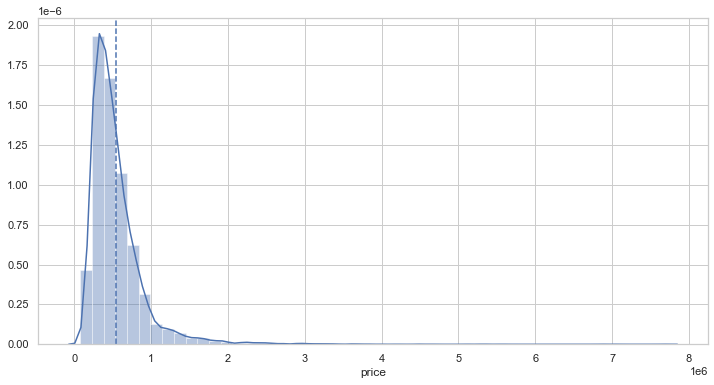

In [26]:
plt.figure(figsize=(12, 6))
sns.distplot(df1['price'])
plt.axvline(df1['price'].mean(), label='Mean', linestyle='--')
plt.show()

## 1.7 Check Outliers -- aqui ou em outra parte?

NÃO SEI BEM COMO CHECAR OUTLIERS... O QUE FAZER???

In [27]:
df1.query('price <= 0')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [28]:
df1.query('bedrooms > 9')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,1773100755,2014-08-21,520000.0,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
13314,627300145,2014-08-14,1148000.0,10,5.25,4590,10920,1.0,0,2,3,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400
15161,5566100170,2014-10-29,650000.0,10,2.00,3610,11914,2.0,0,0,4,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914
15870,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700
19254,8812401450,2014-12-29,660000.0,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745


In [29]:
df1.query('bedrooms > 10')
# the house with 33 bedrooms with not a huge sqft_living is suspicious, probably a typo

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,1773100755,2014-08-21,520000.0,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
15870,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


In [30]:
df1.drop(df1.index[15870], inplace=True)

In [31]:
df1.query('price > 5000000')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1164,1247600105,2014-10-20,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
1315,7558700030,2015-04-13,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1448,8907500070,2015-04-13,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
3914,9808700762,2014-06-11,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
4411,2470100110,2014-08-04,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
7252,6762700020,2014-10-13,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
9254,9208900037,2014-09-19,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


In [32]:
df1.query('bedrooms < 1')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,6306400140,2014-06-12,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
3119,3918400017,2015-02-05,380000.0,0,0.00,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
3467,1453602309,2014-08-05,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
4868,6896300380,2014-10-02,228000.0,0,1.00,390,5900,1.0,0,0,2,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000
6994,2954400190,2014-06-24,1295650.0,0,0.00,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
8477,2569500210,2014-11-17,339950.0,0,2.50,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
8484,2310060040,2014-09-25,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685
9773,3374500520,2015-04-29,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
9854,7849202190,2014-12-23,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
12653,7849202299,2015-02-18,320000.0,0,2.50,1490,7111,2.0,0,0,3,7,1490,0,1999,0,98065,47.5261,-121.826,1500,4675


In [33]:
len(df1.query('bathrooms < 1'))

86

In [34]:
len(df1.query('year_renovated < 1900'))
# 20699 houses weren't renovated anytime since they were built
# will this value of the variable confuse the algorithm?

20698

In [35]:
df1.bedrooms.value_counts().sort_index()

0       13
1      199
2     2760
3     9824
4     6882
5     1601
6      272
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

In [36]:
# plt.bar(x=range(0, 13), height=df1.bedrooms.value_counts().sort_index())
# plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8]) # pois não dá pra ver os outros valores, muito pequenos
# plt.show();

# tá dando erro, não sei pq

In [37]:
len(df1.query('bedrooms == 5'))

1601

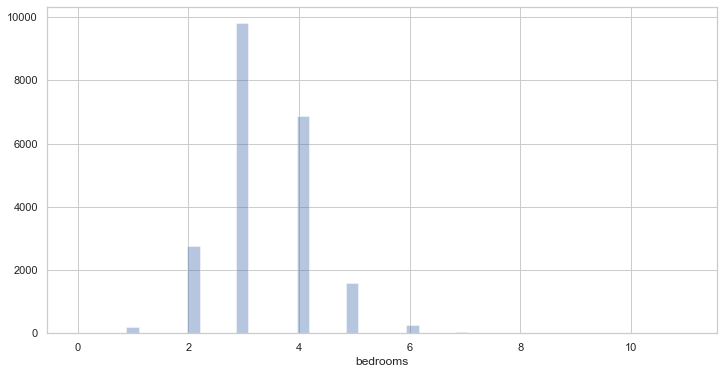

In [38]:
sns.distplot(df1.bedrooms, hist=True, kde=False)

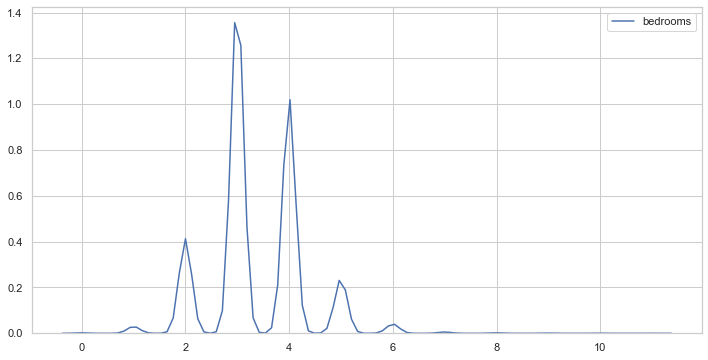

In [39]:
sns.kdeplot(df1.bedrooms)

In [40]:
df1.bathrooms.value_counts().sort_index()

0.00      10
0.50       4
0.75      72
1.00    3852
1.25       9
1.50    1446
1.75    3047
2.00    1930
2.25    2047
2.50    5380
2.75    1185
3.00     753
3.25     589
3.50     731
3.75     155
4.00     136
4.25      79
4.50     100
4.75      23
5.00      21
5.25      13
5.50      10
5.75       4
6.00       6
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
8.00       2
Name: bathrooms, dtype: int64

# 2.0 Feature Engineering

In [41]:
df2 = df1.copy()

## 2.1 Hypothesis Mental Map

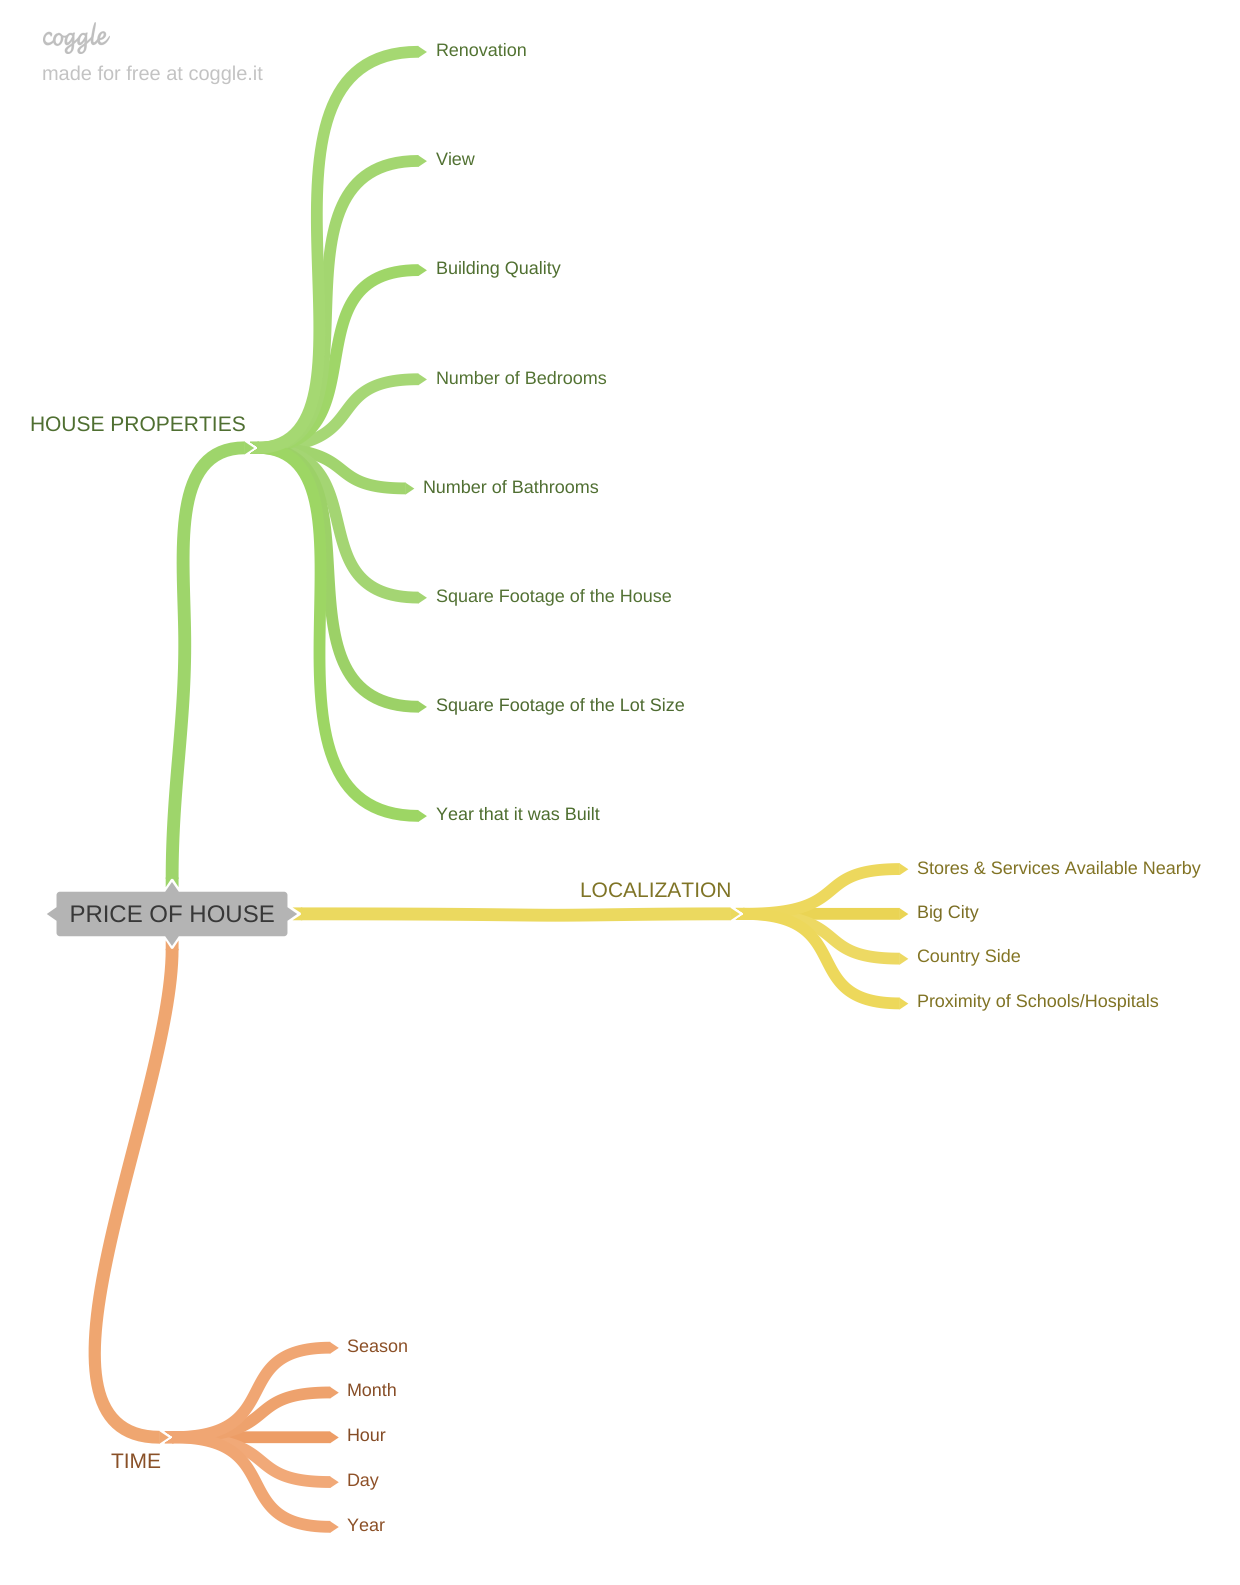

In [42]:
Image('price_of_house_mind_map_hypothesis.png')

## 2.2 Hypothesis Generation

### 2.2.1 House Properties Hypothesis

1. Houses with more Bedrooms are MORE EXPENSIVE
2. Houses with more Bathrooms are MORE EXPENSIVE
3. Houses with a Higher Quality Building are MORE EXPENSIVE
4. Houses with a better View are MORE EXPENSIVE
5. Bigger Houses are MORE EXPENSIVE
6. Houses with bigger Areas are MORE EXPENSIVE
7. Older Houses are CHEAPER
8. Renovated Houses are MORE EXPENSIVE
9. Houses that were Renovated recently are MORE EXPENSIVE

### 2.2.2 Localization Hypothesis

1. Houses in Big City are MORE EXPENSIVE than Houses in the Country Side
2. Houses with more Stores and Services nearby ARE MORE EXPENSIVE

### 2.2.3 Time Hypothesis

1. There are MORE Houses sold during the weekend

2. MORE Houses are sold during the Summer and Spring

In [43]:
# Probably something can be done with the Latitude and Longitude about these hypothesis, but it envolves too much work

## 2.3 Hypothesis Final List

In [44]:
# priorize hypothesis to later use in the Exploratory Data Analysis

# how to priorize the hypothesis?  --> do you have the data available and ready to prove the hypothesis?

1. Houses with more Bedrooms are MORE EXPENSIVE
2. Houses with more Bathrooms are MORE EXPENSIVE
3. Houses with a Higher Quality Building are MORE EXPENSIVE
4. Houses with a better View are MORE EXPENSIVE
5. Bigger Houses are MORE EXPENSIVE
6. Houses with bigger Areas are MORE EXPENSIVE
7. Older Houses are CHEAPER
8. Renovated Houses are MORE EXPENSIVE
9. Houses that were Renovated recently are MORE EXPENSIVE
10. There are MORE Houses sold during the weekend

## 2.4 Feature Engineering

In [45]:
df2.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'year_built', 'year_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [46]:
df2['sqft_non_living'] = df2['sqft_lot'] - df2['sqft_living']
df2[['sqft_living', 'sqft_lot', 'sqft_non_living']].head()

,sqft_living,sqft_lot,sqft_non_living
0,1180,5650,4470
1,2570,7242,4672
2,770,10000,9230
3,1960,5000,3040
4,1680,8080,6400


In [47]:
# extract date columns

df2['day'] = df2['date'].dt.day

df2['month'] = df2['date'].dt.month

df2['year'] = df2['date'].dt.year

df2['week_of_year'] = df2['date'].dt.weekofyear

df2['day_of_week'] = df2['date'].dt.dayofweek # 0 is Monday, up to 6 --> Sunday

df2.sample(5).T

,5633,16322,333,5932,7520
id,3424069145,1972200725,9550201550,7625704317,1049000740
date,2014-09-25 00:00:00,2015-04-07 00:00:00,2015-04-08 00:00:00,2015-05-03 00:00:00,2014-11-20 00:00:00
price,343000,620000,640000,377500,229950
bedrooms,3,3,2,2,2
bathrooms,1,2.5,1,1,1.5
sqft_living,1400,1776,1070,840,1160
sqft_lot,5662,1248,5000,4500,1848
floors,1.5,3,1,1,2
waterfront,0,0,0,0,0
view,0,0,0,0,0


In [48]:
# week_of_year --> 1 up to 52 (no years in this data had 53 weeks) (2014 nor 2015)
def season(week_of_year):
    if week_of_year >= 10 and week_of_year < 23:
        week_of_year = 'Spring'
    elif week_of_year >= 23 and week_of_year < 36:
        week_of_year = 'Summer'
    elif week_of_year >= 36 and week_of_year < 49:
        week_of_year = 'Fall'
    else:
        week_of_year = 'Winter'
        
    return week_of_year
        
df2['season'] = df2['week_of_year'].apply(season)

In [49]:
# df2['season'] = df2['week_of_year'].apply( lambda x: 'Spring' if x >= 10 and x < 23 else 'Summer' if x >= 23 and x < 36 else 'Fall' if x >= 36 and x < 49 else 'Winter' )

In [50]:
df2[['date', 'week_of_year', 'season']].tail(5)

,date,week_of_year,season
21608,2014-05-21,21,Spring
21609,2015-02-23,9,Winter
21610,2014-06-23,26,Summer
21611,2015-01-16,3,Winter
21612,2014-10-15,42,Fall


# 3.0 Filtragem de Variáveis

In [51]:
df3 = df2.copy()

In [52]:
# Will the sqft of the 15 nearest neighbors be available for new predctions?

## 3.1 Filtragem das Linhas

In [53]:
# I'm gonna make a copy without possible outliers, and later compare the results

In [54]:
# filtering outliers
# The operators are: | for or, & for and, and ~ for not. These must be grouped by using parentheses.
# possible usage df[df['column name'].map(len) < 2]

df3_without_outliers = df3.drop(df3[(df3['bathrooms'] < 1) | (df3['bedrooms'] < 1)].index)
# 91 lines dropped

## 3.2 Seleção das Colunas

# 4.0 Análise Exploratória dos Dados

## 4.1 Análise Univariada

### 4.1.1 Response Variable (Variável Resposta)

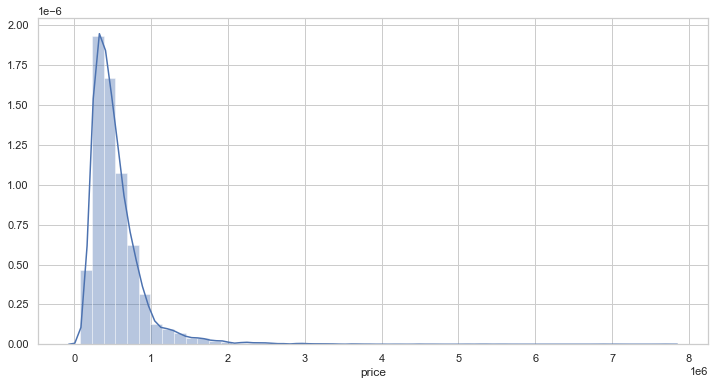

In [55]:
sns.distplot(df3['price']);

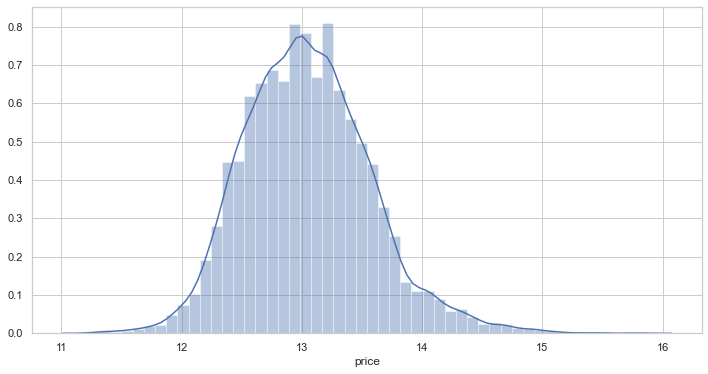

In [56]:
sns.distplot(np.log1p(df3['price']));
# applying log makes the distribution of price really looks like a normal dist

### 4.1.2 Numerical Variables

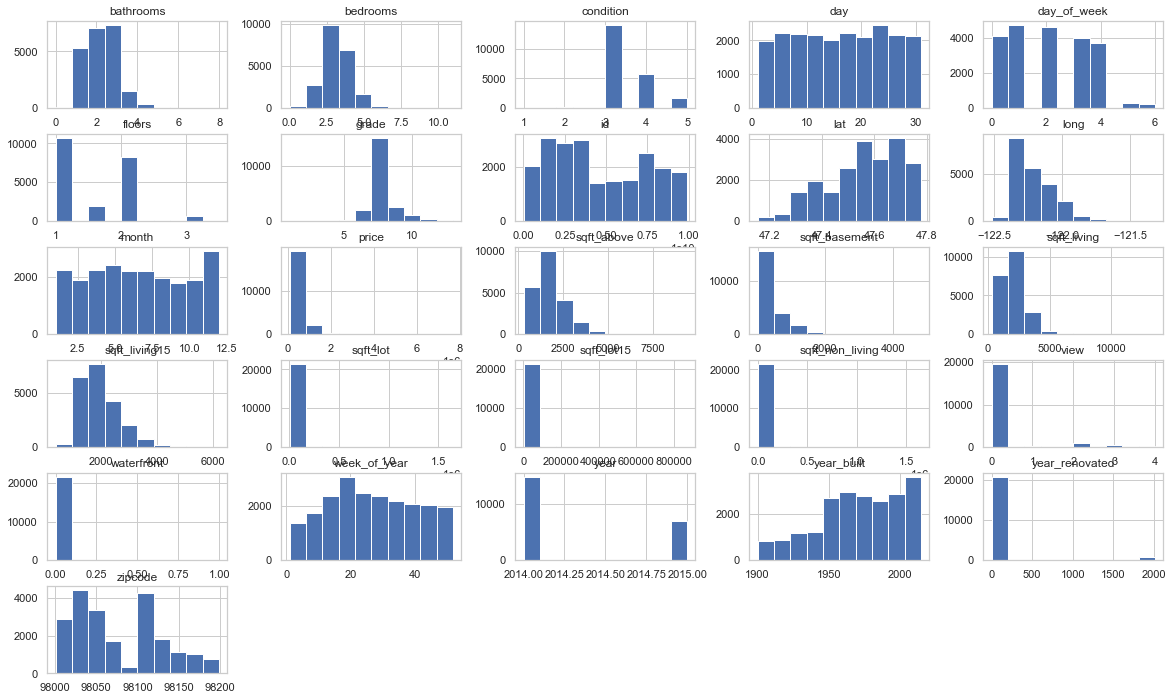

In [57]:
df3.hist(figsize=(20,12));

In [58]:
print(len(df3.query('waterfront == 0')))
print(len(df3.query('waterfront == 1')))

21449
163


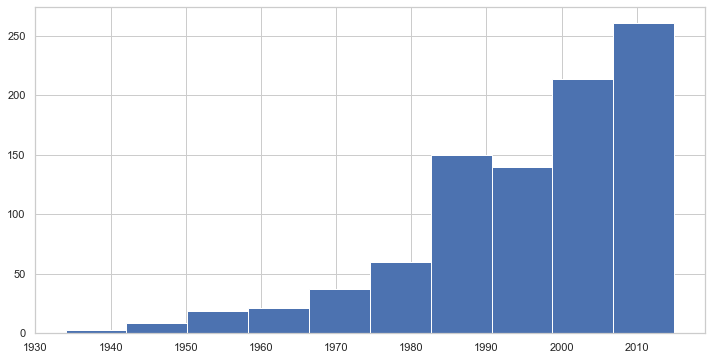

In [59]:
df3[df3['year_renovated'] > 0]['year_renovated'].hist();

## 4.2 Análise Bivariada

### 4.2.1 **Hypothesis** 1 - Houses with more Bedrooms are MORE EXPENSIVE
- ***True up to a certain number of bedrooms (in this case, 8)*** - for some motive, houses with more than 8 bedrooms tend to be a bit cheaper than houses with 7-8 bedrooms, maybe because they tend to be smaller (just a guess)

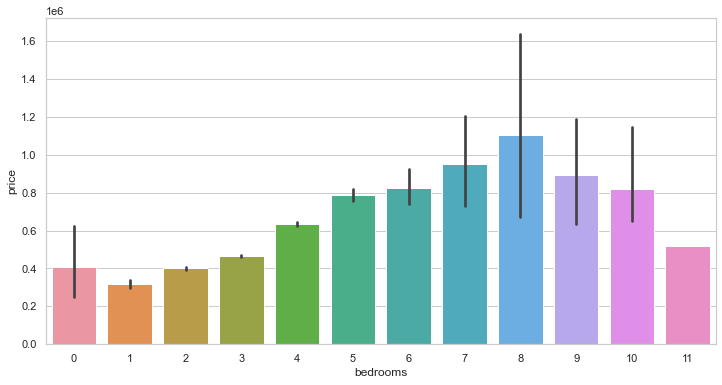

In [60]:
sns.barplot(data=df3, x='bedrooms', y='price', estimator=mean);

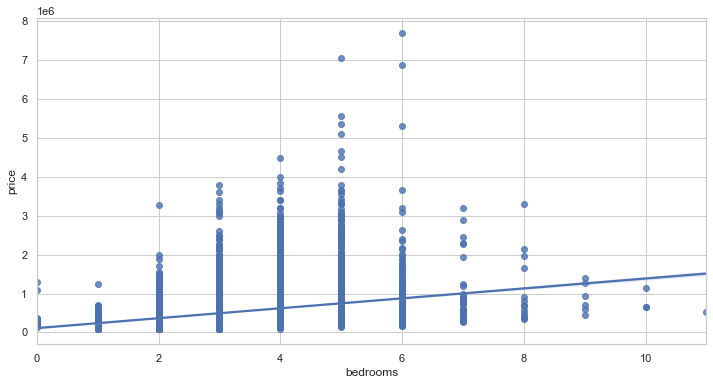

In [61]:
sns.regplot(data = df3, x='bedrooms', y='price');

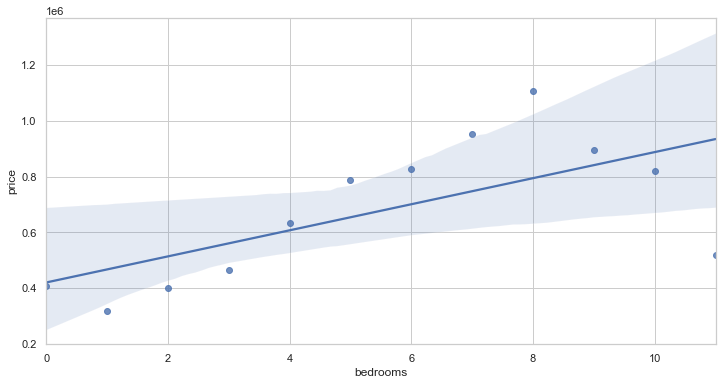

In [62]:
aux1 = df3[['bedrooms', 'price']].groupby('bedrooms').mean().reset_index()
sns.regplot(x='bedrooms', y='price', data=aux1);

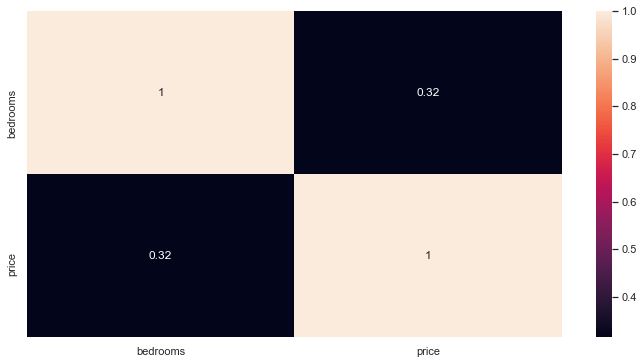

In [63]:
sns.heatmap(df3[['bedrooms', 'price']].corr(), annot=True);

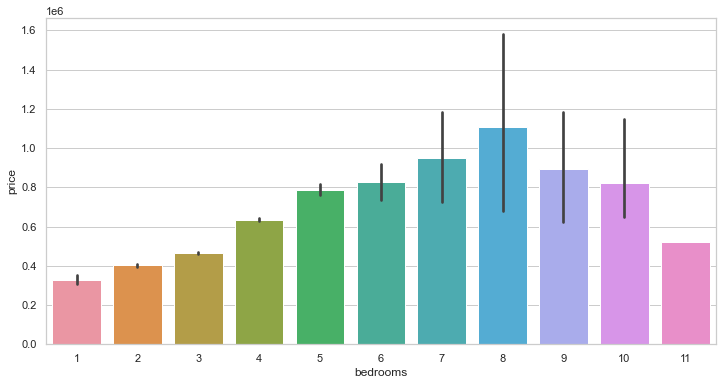

In [64]:
sns.barplot(data=df3_without_outliers, x='bedrooms', y='price', estimator=mean);

### 4.2.2 **Hypothesis** 2 - Houses with more Bathrooms are MORE EXPENSIVE
- ***True*** - although it isn't a straight upward increase

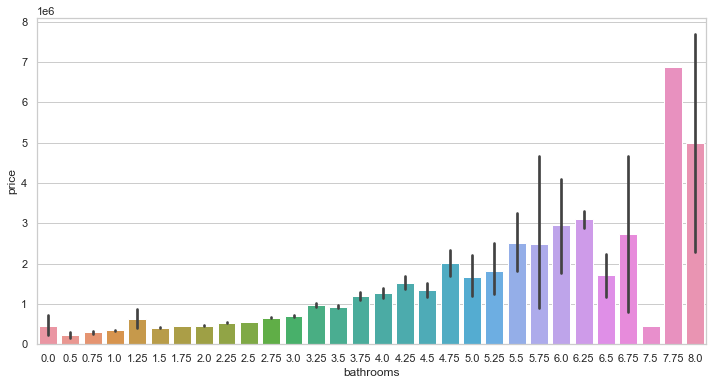

In [65]:
sns.barplot(data=df3, x='bathrooms', y='price');

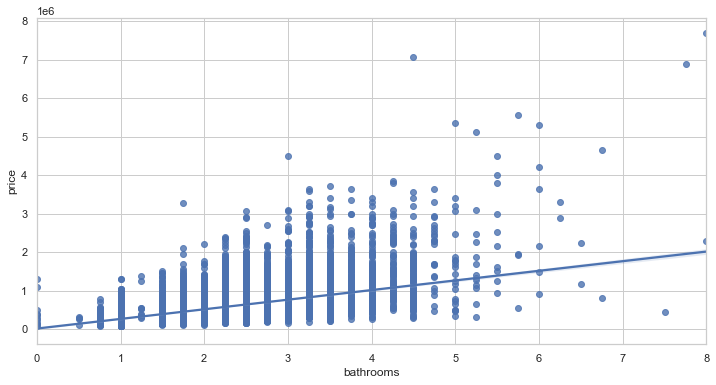

In [66]:
sns.regplot(data=df3, x='bathrooms', y='price');

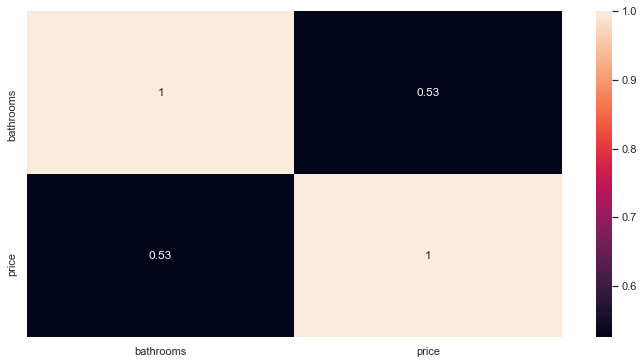

In [67]:
sns.heatmap(data=df3[['bathrooms', 'price']].corr(), annot=True);

### 4.2.3 **Hypothesis 3** - Houses with a Higher Quality Building are MORE EXPENSIVE
- ***True***

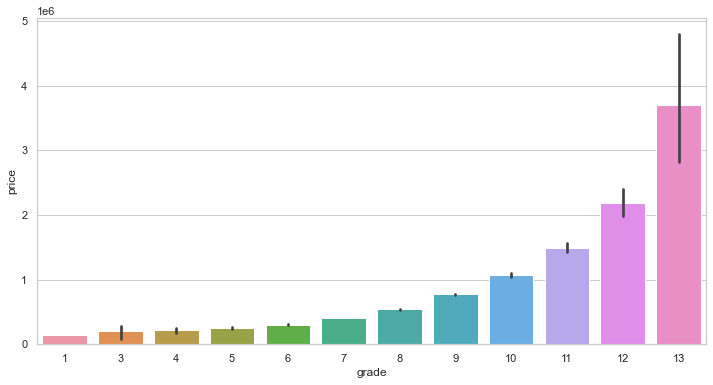

In [68]:
sns.barplot(data=df3, x='grade', y='price');

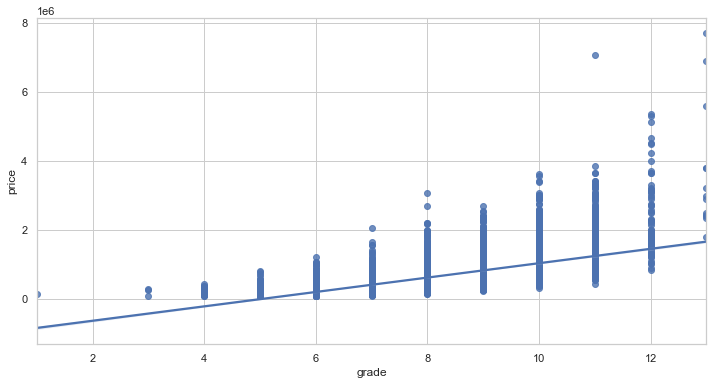

In [69]:
sns.regplot(data=df3, x='grade', y='price');

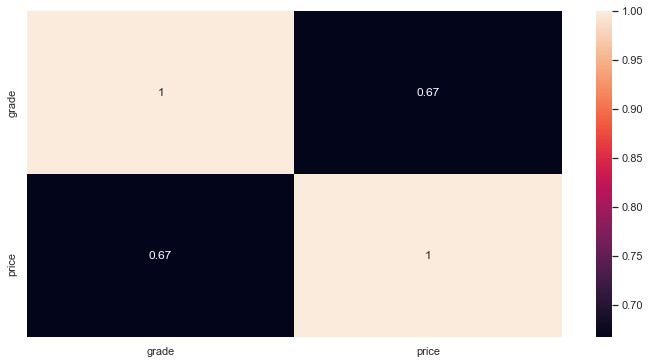

In [70]:
sns.heatmap(data=df3[['grade', 'price']].corr(method='pearson'), annot=True);
#sns.heatmap(data=aux1.corr(method='pearson'), annot=True);

### 4.2.4 **Hypothesis 4** - Houses with a better View are MORE EXPENSIVE
- ***True***

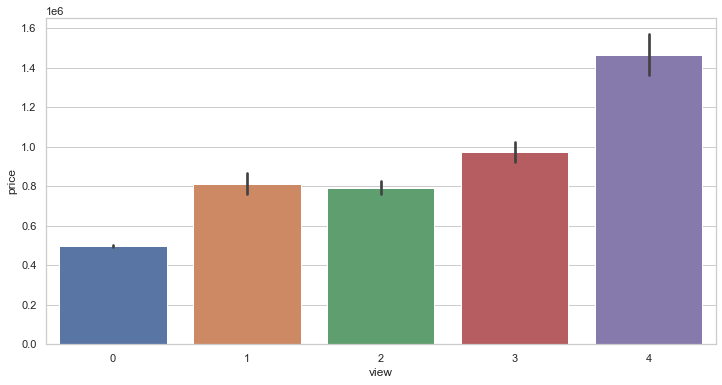

In [71]:
sns.barplot(x='view', y='price', data=df3);

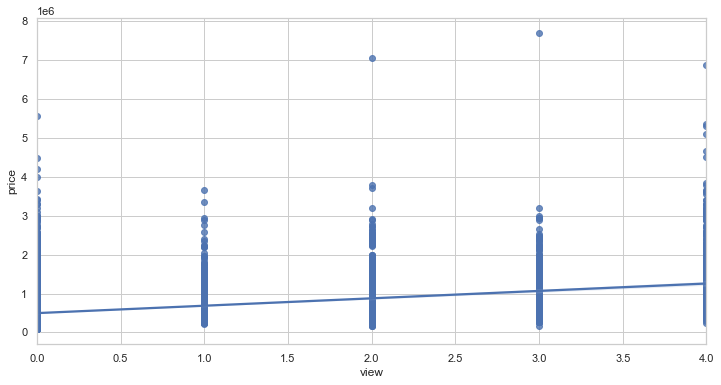

In [72]:
sns.regplot(x='view', y='price', data=df3);

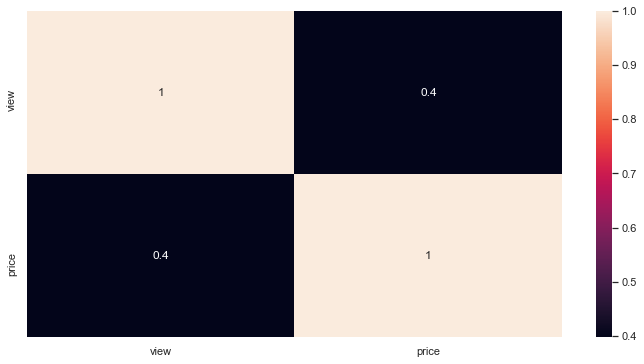

In [73]:
sns.heatmap(data=df3[['view', 'price']].corr(), annot=True);

### 4.2.5 **Hypothesis 5** - Bigger Houses are MORE EXPENSIVE
- ***True***

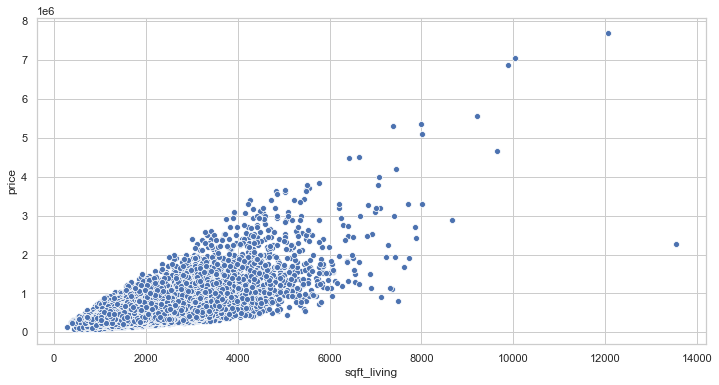

In [74]:
sns.scatterplot('sqft_living', 'price', data=df3);

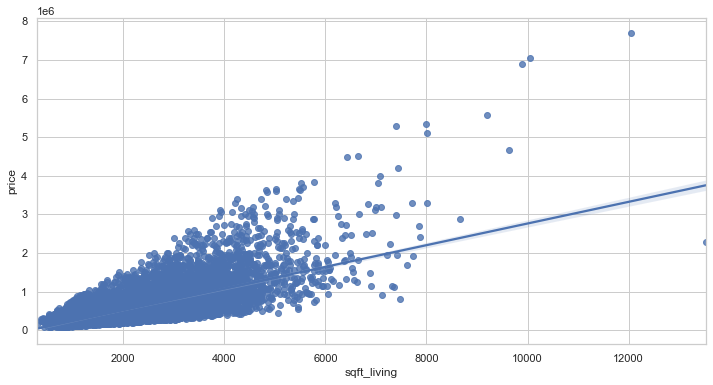

In [75]:
sns.regplot('sqft_living', 'price', data=df3);

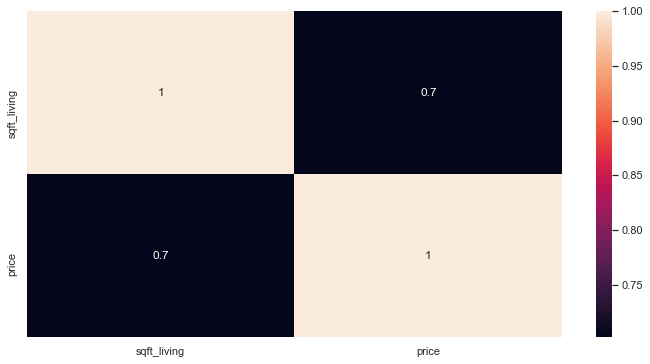

In [76]:
sns.heatmap(data=df3[['sqft_living', 'price']].corr(), annot=True);

### 4.2.6 **Hypothesis 6** - Houses with bigger Areas are MORE EXPENSIVE
- ***True, but*** - there is a small positive correlation (a higher was expected). It may be related to something like: houses with bigger areas tend to be in the Country Side, so they are less expensive due to this fact. House with small areas are probably in big cities, thus, they cost way more per sqft.

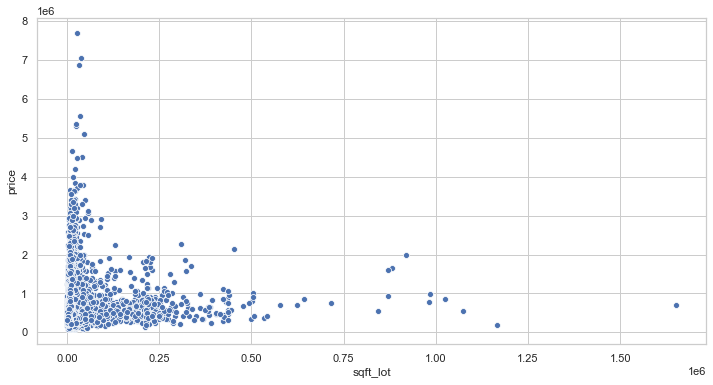

In [77]:
sns.scatterplot('sqft_lot', 'price', data=df3);

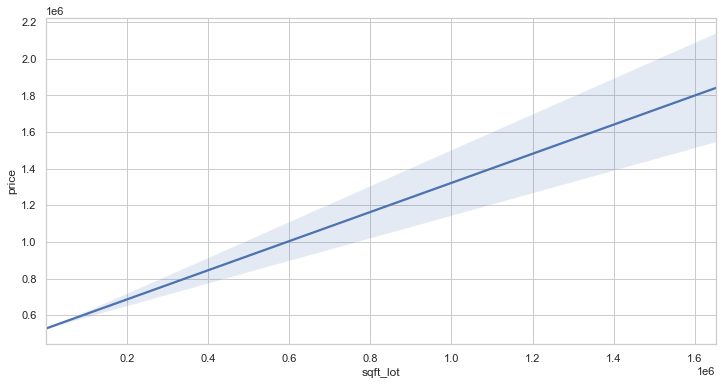

In [78]:
sns.regplot('sqft_lot', 'price', data=df3, scatter=False);

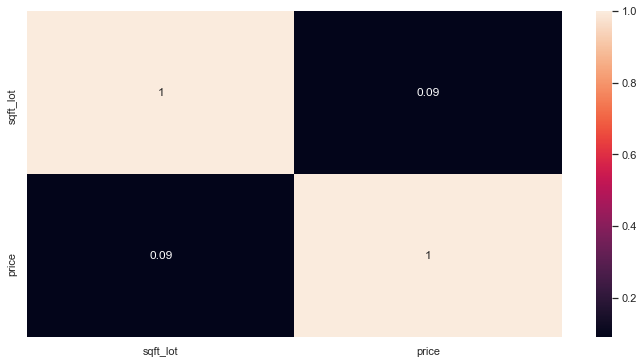

In [79]:
sns.heatmap(data=df3[['sqft_lot', 'price']].corr(), annot=True);

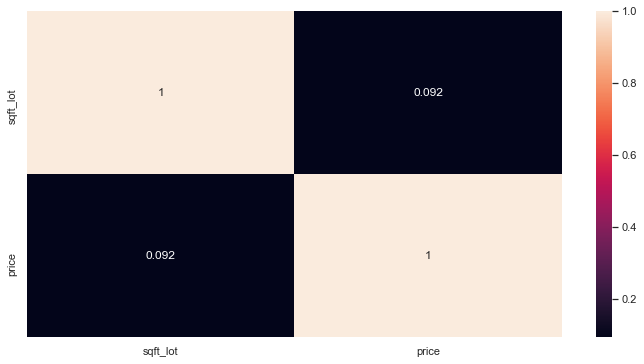

In [80]:
aux = df3[df3['sqft_lot'] < 750000]
sns.heatmap(data=aux[['sqft_lot', 'price']].corr(), annot=True);

### 4.2.7 **Hypothesis 7** - Older Houses are CHEAPER
- ***Kind of False?*** - There is a positive correlation. but it's really small, it seems almost constant

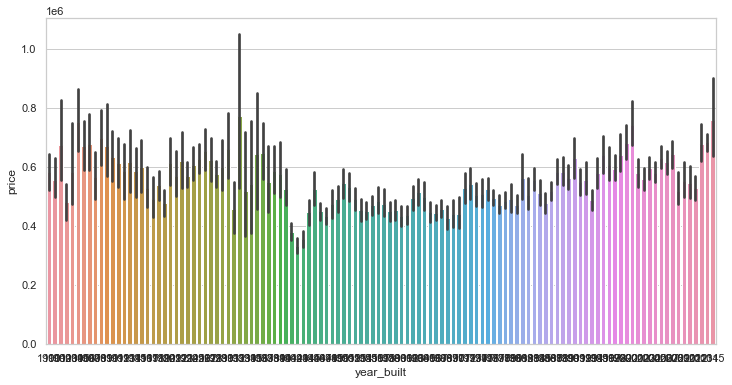

In [81]:
sns.barplot('year_built', 'price', data=df3);

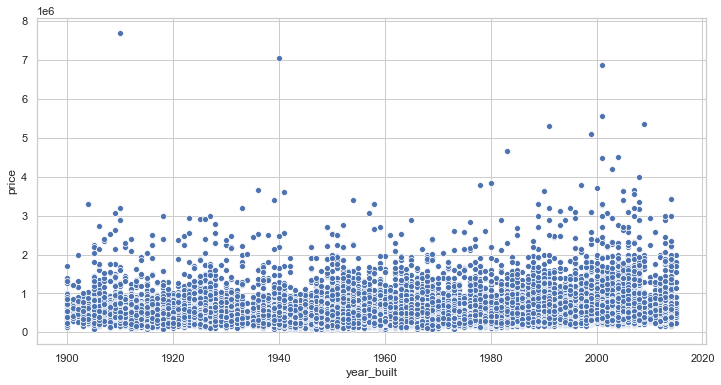

In [82]:
sns.scatterplot('year_built', 'price', data=df3);

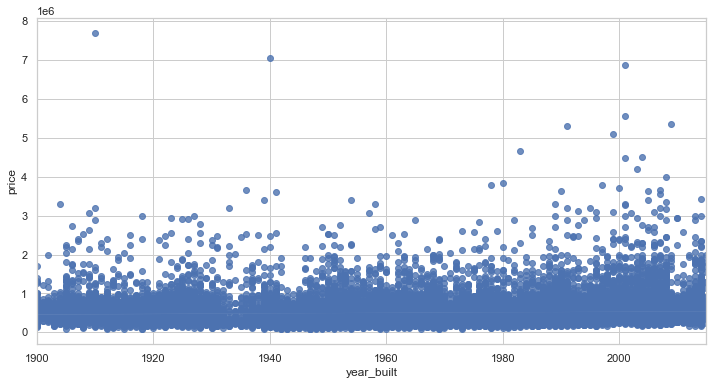

In [83]:
sns.regplot('year_built', 'price', data=df3)

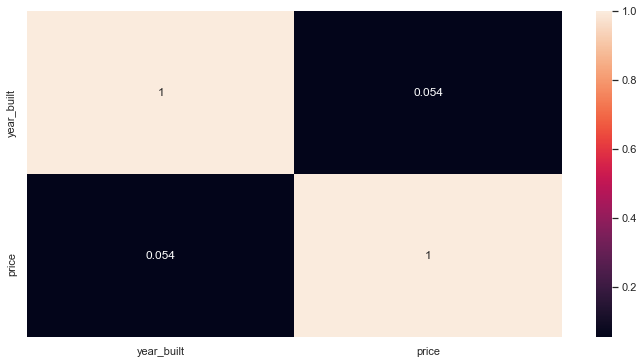

In [84]:
sns.heatmap(data=df3[['year_built', 'price']].corr(), annot=True);

### 4.2.8 **Hypothesis 8** - Renovated Houses are MORE EXPENSIVE
- ***True*** - but only to a small degree

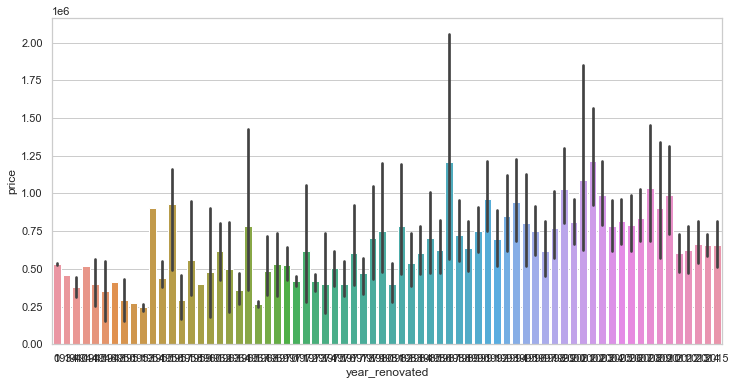

In [85]:
sns.barplot('year_renovated', 'price', data=df3);

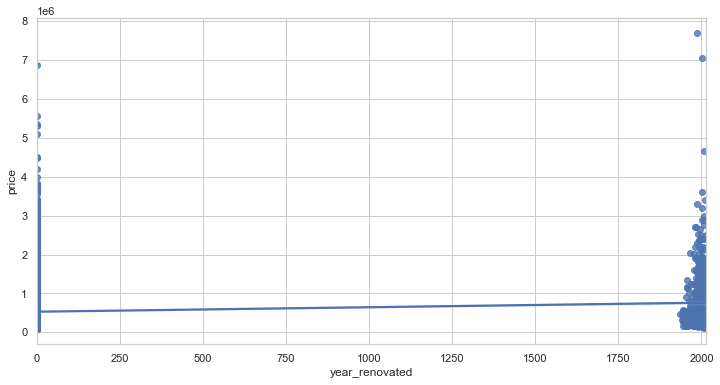

In [86]:
sns.regplot('year_renovated', 'price', data=df3);

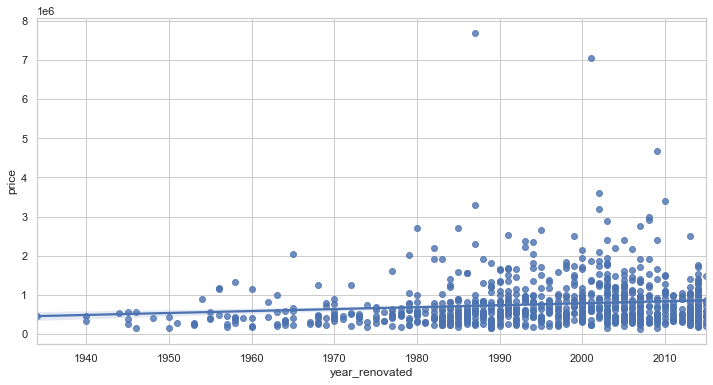

In [87]:
# plotting only houses that were renovated
renovated = df3[df3['year_renovated'] > 0]
sns.regplot('year_renovated', 'price', data=renovated);

In [88]:
print('Mean Price of Houses that were renovated: {}'.format(aux['price'].mean()))
print('Mean Price of Houses that were NOT renovated: {}'.format(df3[df3['year_renovated'] == 0]['price'].mean()))
print('Mean Price of all Houses: {}'.format(df3['price'].mean()))

Mean Price of Houses that were renovated: 539858.0624971066
Mean Price of Houses that were NOT renovated: 530355.5210648372
Mean Price of all Houses: 540083.5187858597


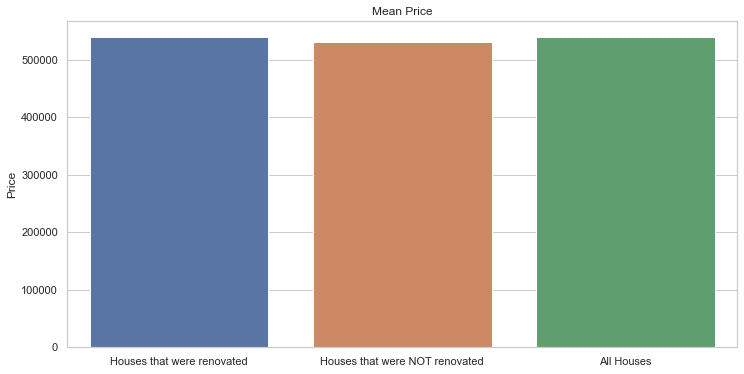

In [89]:
sns.barplot(x=['Houses that were renovated', 'Houses that were NOT renovated', 'All Houses'], y=[aux['price'].mean(), df3[df3['year_renovated'] == 0]['price'].mean(), df3['price'].mean()]);
plt.title('Mean Price');
plt.ylabel('Price');

In [90]:
len(renovated)

914

In [91]:
len(df3[df3['year_renovated'] == 0])

20698

### 4.2.9 **Hypothesis 9** - Houses that were Renovated recently are MORE EXPENSIVE
- ***True***

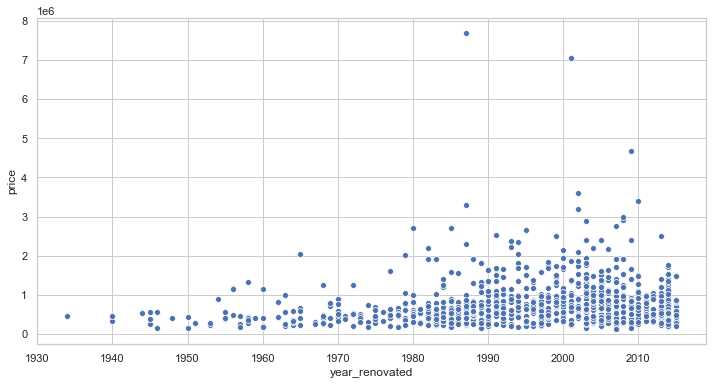

In [92]:
sns.scatterplot('year_renovated', 'price', data=renovated);

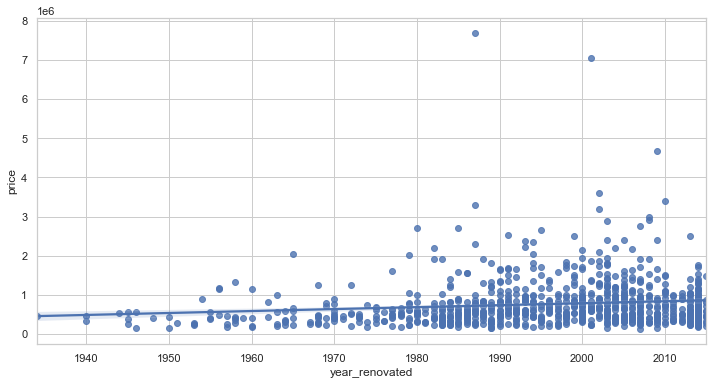

In [93]:
sns.regplot('year_renovated', 'price', data=renovated);

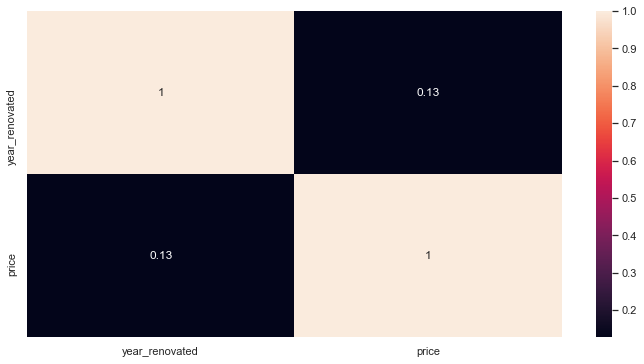

In [94]:
sns.heatmap(data=renovated[['year_renovated', 'price']].corr(), annot=True);

### 4.2.10 **Hypothesis 10** - Houses in a better Condition are MORE EXPENSIVE
- ***True or False / inconclusive*** - considerations

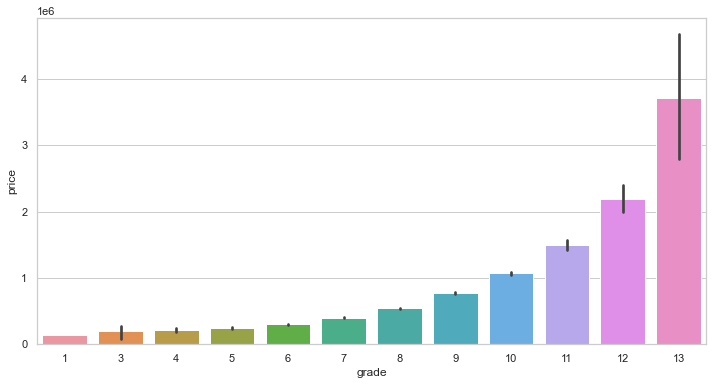

In [95]:
sns.barplot('grade', 'price', data=df3);

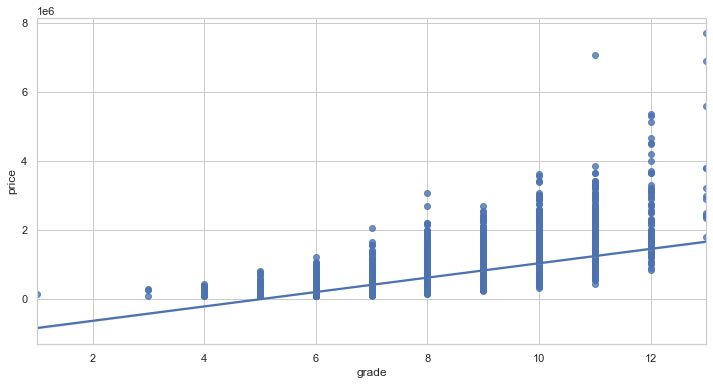

In [96]:
sns.regplot('grade', 'price', data=df3);

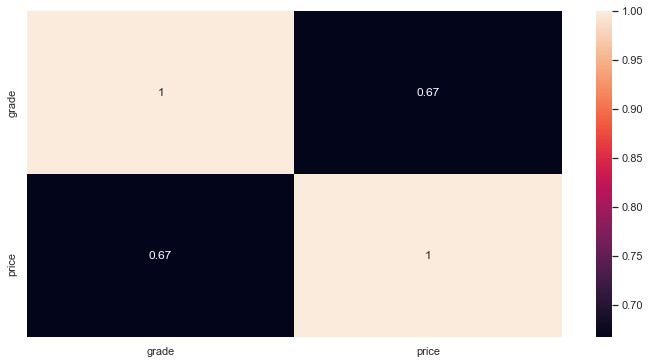

In [97]:
sns.heatmap(data=df3[['grade', 'price']].corr(method='pearson'), annot=True);

### 4.2.11 **Hypothesis 11** - Houses that area Waterfront are MORE EXPENSIVE
- ***True***

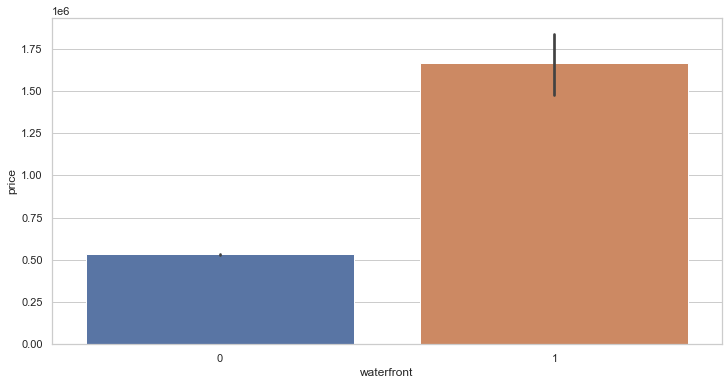

In [98]:
sns.barplot('waterfront', 'price', data=df3);

In [99]:
#sns.regplot('waterfront', 'price', data=df3);
# it probably does not make any sense using this kind of correlation to a binary feature

### 4.2.12 **Hypothesis 12** -  There are MORE Houses sold during the weekend
- ***False*** - There are way LESS Houses sold during the weekend

Insights:
- There are way LESS Houses sold during the weekend
- the first weeks of the year tend to sell LESS, which includes January and February
- Excluding Jan and Feb, the last 2 months sell LESS (November and December)
- Fall sell way LESS than Summer and Spring, and Winter sell way less then Fall

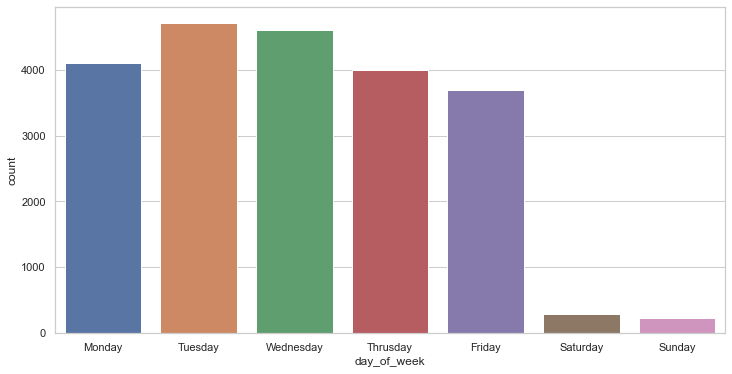

In [100]:
sns.countplot('day_of_week', data=df3);
plt.xticks([0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday', 'Saturday', 'Sunday']);

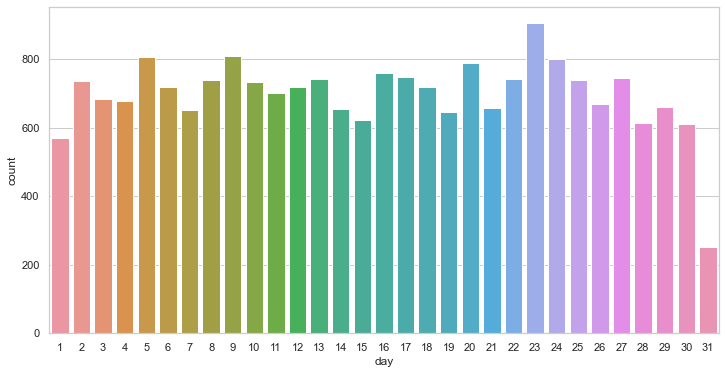

In [101]:
sns.countplot('day', data=df3);

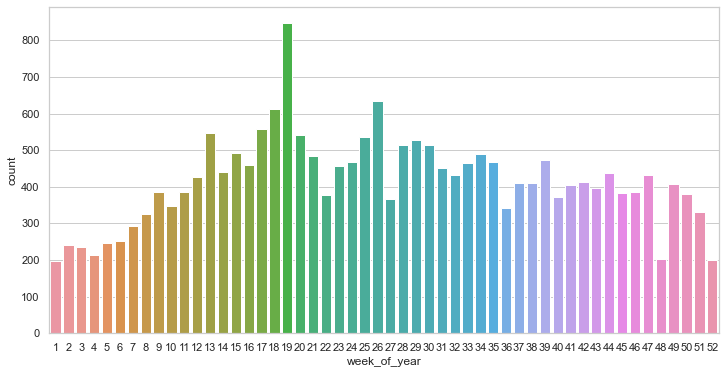

In [102]:
sns.countplot('week_of_year', data=df3);

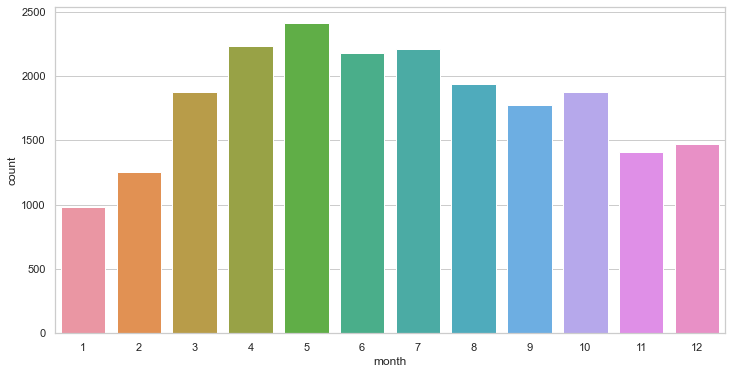

In [103]:
sns.countplot('month', data=df3);

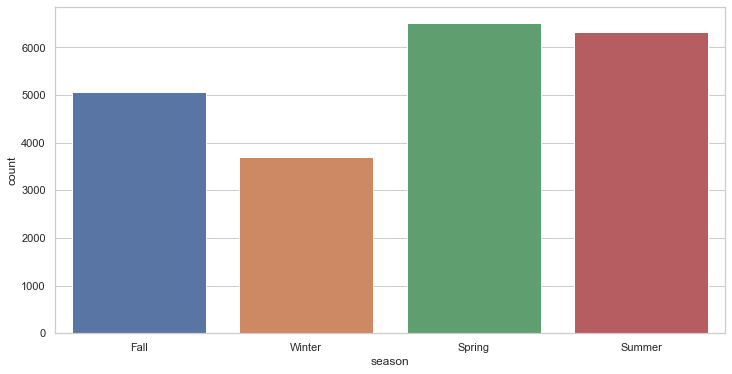

In [104]:
sns.countplot('season', data=df3);

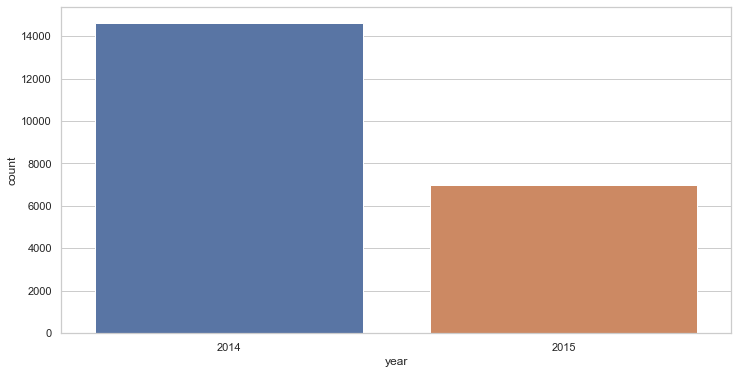

In [105]:
sns.countplot('year', data=df3);
# we only have data until 27th may 2015

### 4.2.13 **Hypothesis 13** -  The Houses sold during the weekend are MORE EXPENSIVE
- ***False*** - The sales' price is equally distributed between:
- the days of the week and weekend
- the days of the month
- the weeks of year
- the months
- the seasons
- the years

Day of Week

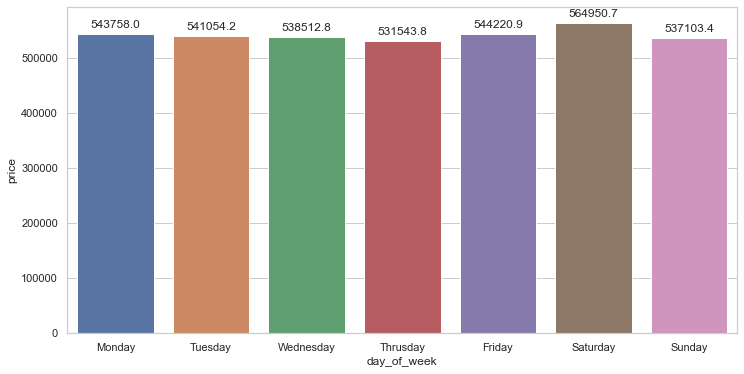

In [106]:
# 0 is Monday, 1 is Tuesday, 2 is Wednesday, 3 is Thrusday, 4 is Friday, 5 is Saturday, 6 is Sunday
splot = sns.barplot('day_of_week', 'price', data=df3, ci=None, estimator=mean);

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.xticks([0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday', 'Saturday', 'Sunday']);

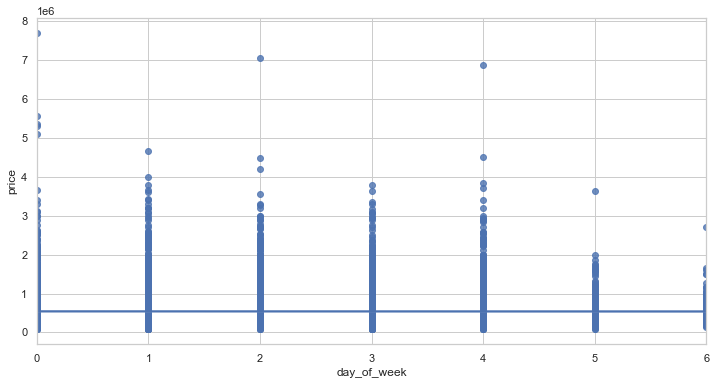

In [107]:
sns.regplot('day_of_week', 'price', data=df3);

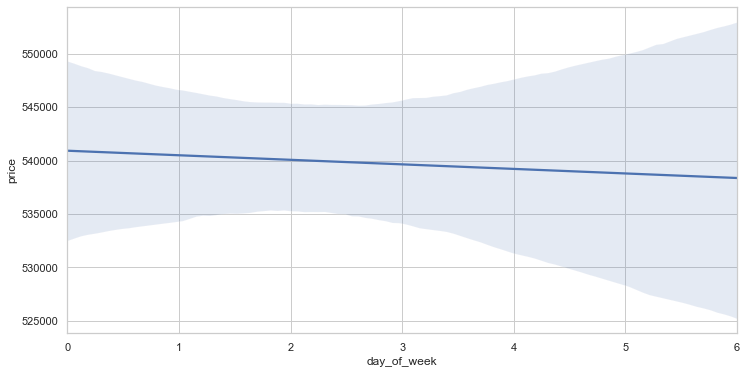

In [108]:
sns.regplot('day_of_week', 'price', data=df3, scatter=False);

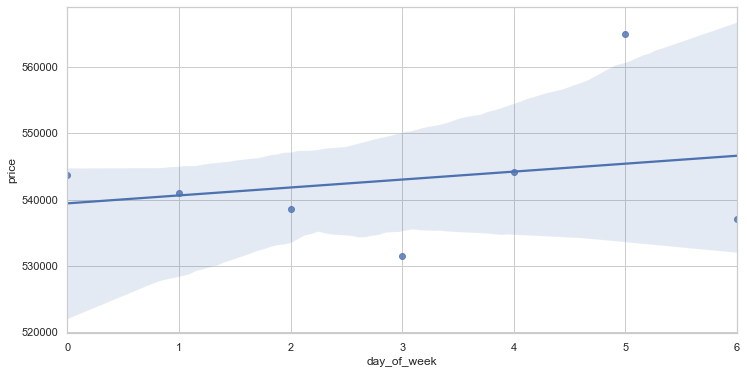

In [109]:
aux1 = df3[['day_of_week', 'price']].groupby( 'day_of_week' ).mean().reset_index()
sns.regplot(x='day_of_week', y='price', data=aux1);

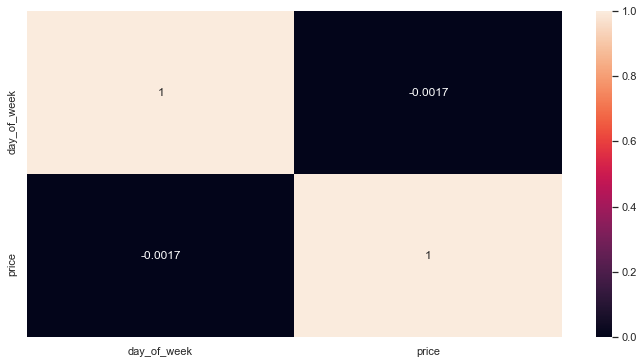

In [110]:
sns.heatmap(data=df3[['day_of_week', 'price']].corr(method='pearson'), annot=True);

#### Day of Month

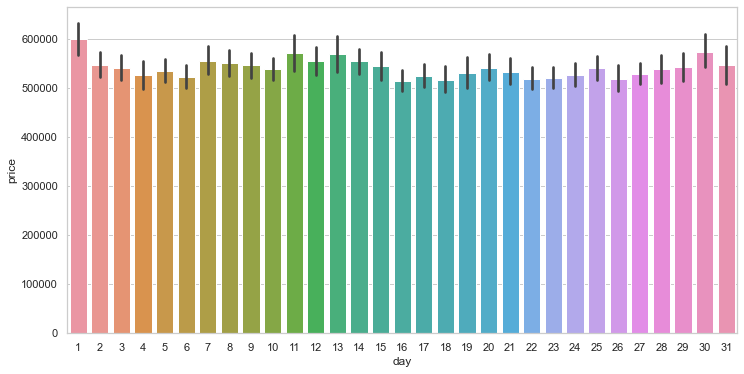

In [111]:
sns.barplot(x='day', y='price', data=df3);

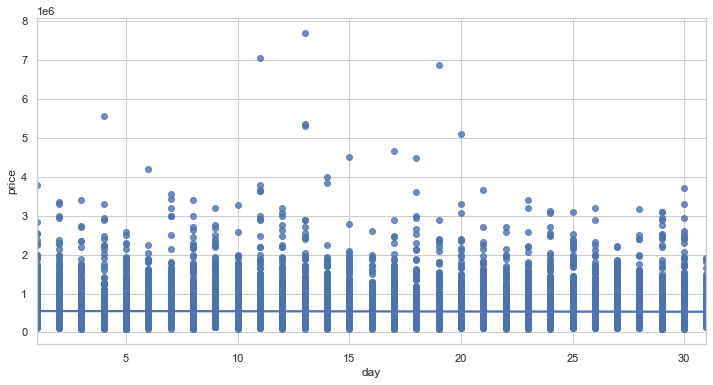

In [112]:
sns.regplot('day', 'price', data=df3);

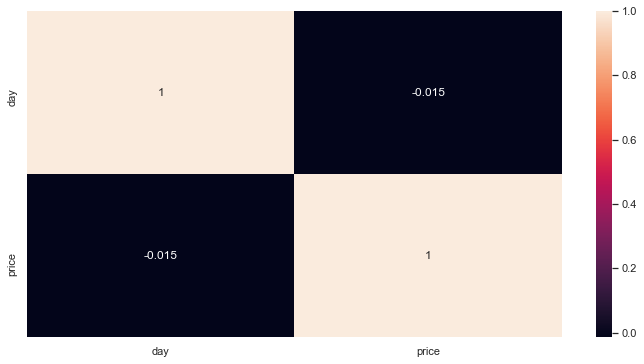

In [113]:
sns.heatmap(data=df3[['day', 'price']].corr(method='pearson'), annot=True);

#### Week of Year

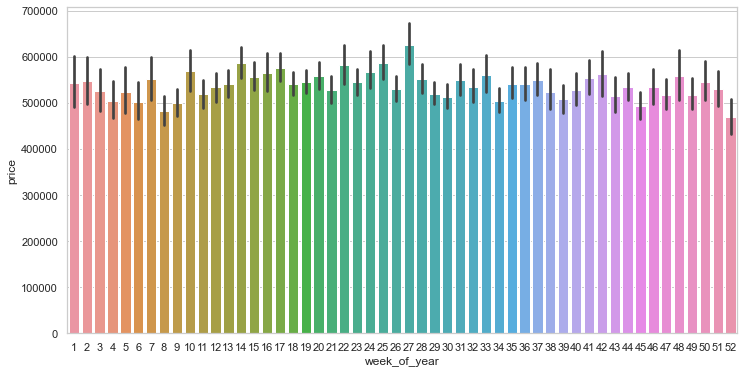

In [114]:
sns.barplot( x='week_of_year', y='price', data=df3 );

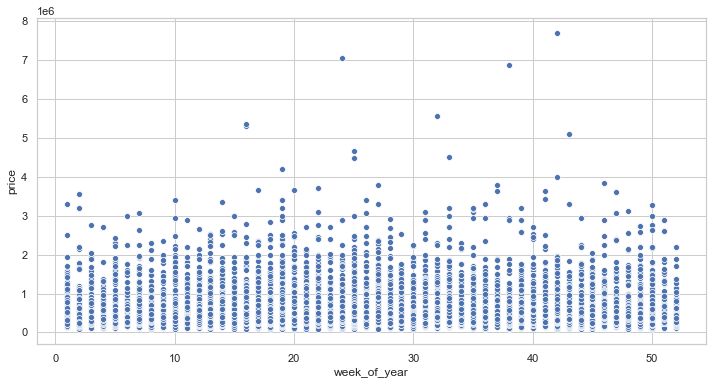

In [115]:
sns.scatterplot( x='week_of_year', y='price', data=df3 );

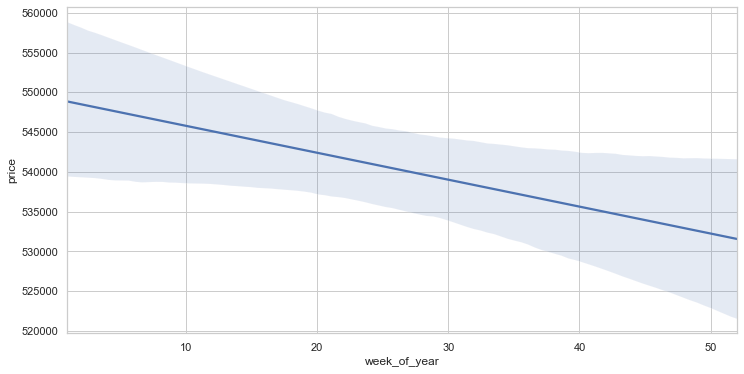

In [116]:
sns.regplot('week_of_year', 'price', data=df3, scatter=False);

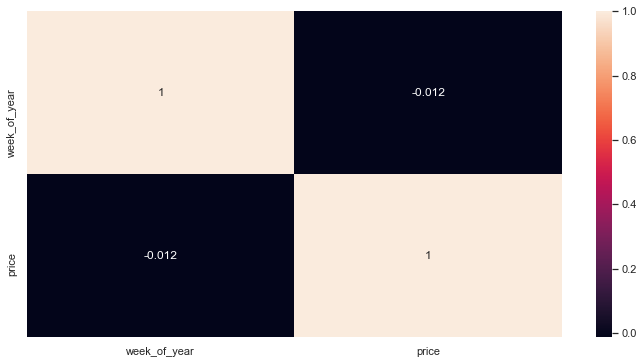

In [117]:
sns.heatmap(data=df3[['week_of_year', 'price']].corr(method='pearson'), annot=True);

#### Month

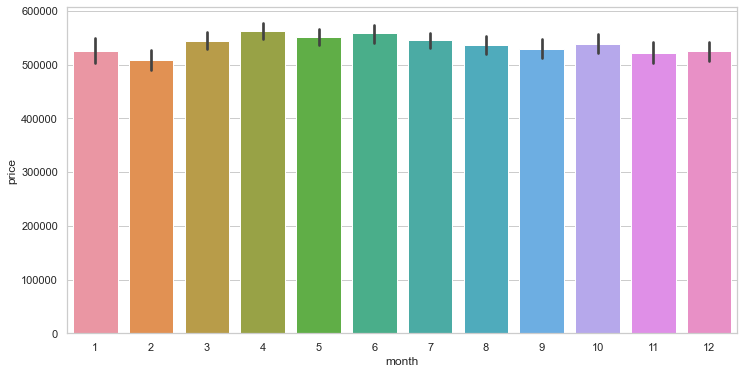

In [118]:
sns.barplot( x='month', y='price', data=df3 );

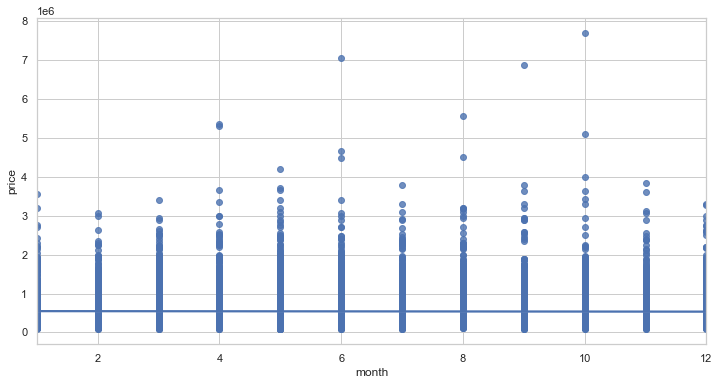

In [119]:
sns.regplot('month', 'price', data=df3);

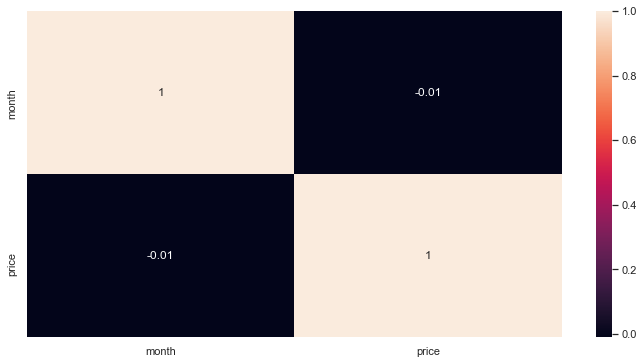

In [120]:
sns.heatmap(data=df3[['month', 'price']].corr(method='pearson'), annot=True);

#### Year

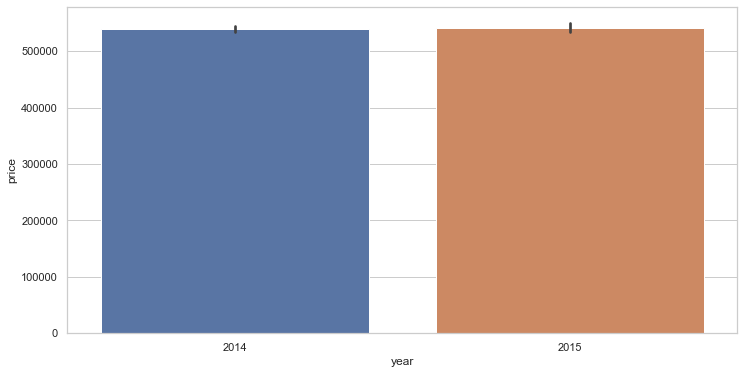

In [121]:
sns.barplot( x='year', y='price', data=df3 );

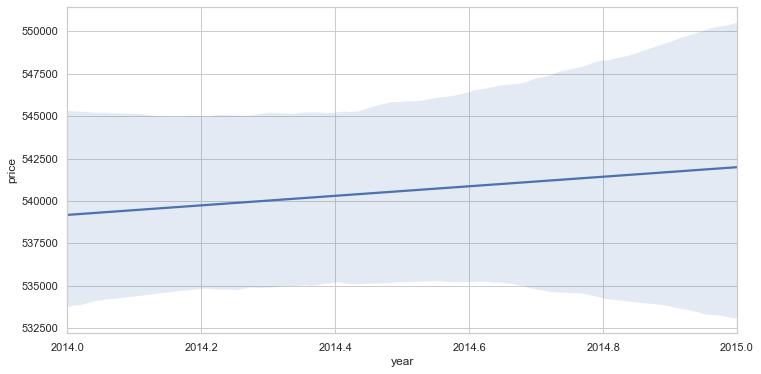

In [122]:
sns.regplot('year', 'price', data=df3, scatter=False);

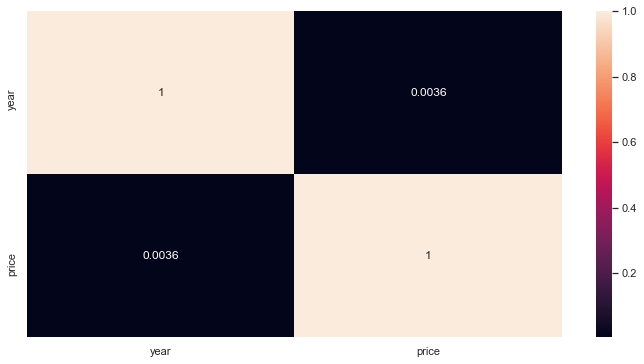

In [123]:
sns.heatmap(data=df3[['year', 'price']].corr(method='pearson'), annot=True);

Season

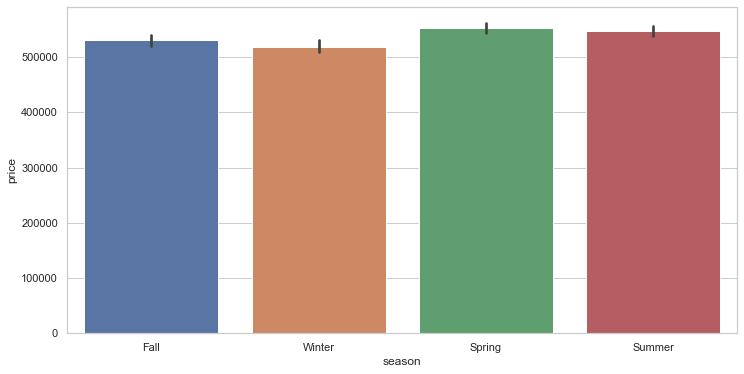

In [124]:
sns.barplot( x='season', y='price', data=df3 );

In [125]:
# I need to study about correlation between non numeric data
#sns.regplot('season', 'price', data=df3, scatter=False);
#sns.heatmap(data=df3[['season', 'price']].corr(method=''), annot=True);

### 4.2.14 **Hypothesis 14** -  The Houses sold during the weekend are MORE EXPENSIVE
- ***True*** - but very similar to H06

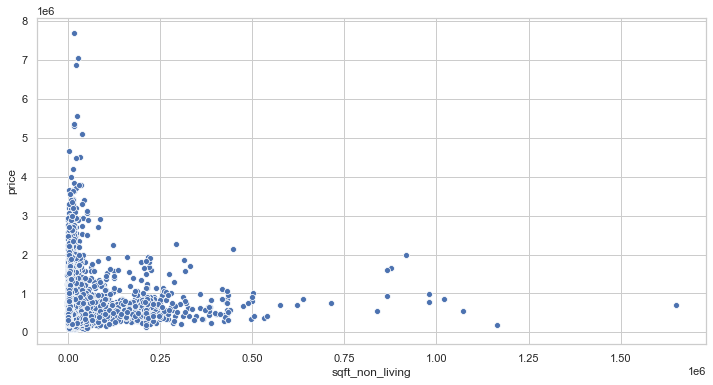

In [126]:
sns.scatterplot('sqft_non_living', 'price', data=df3);

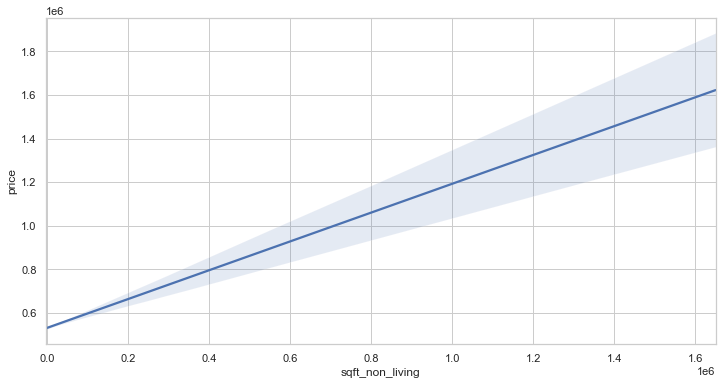

In [127]:
sns.regplot('sqft_non_living', 'price', data=df3, scatter=False);

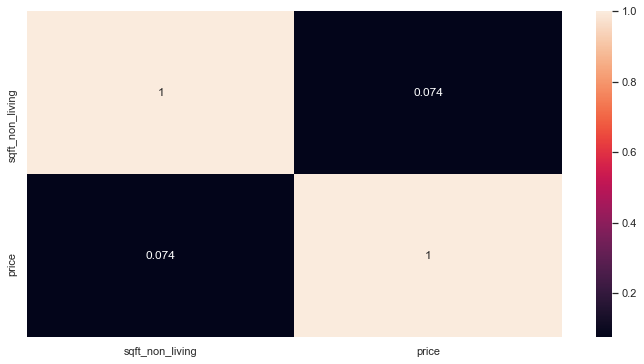

In [128]:
sns.heatmap(data=df3[['sqft_non_living', 'price']].corr(method='pearson'), annot=True);

### 4.2.1 Resumo das Hipóteses 
- Expectativas Inicais a Respeito das Variáveis
- A Hipótese foi Valida ou Rejeitada? 
- Ela pode gerar um Insight ou não? 
- Ela pode ser Relevante para o Modelo?

- OBS: ISSO TUDO É DE FORMA EMPÍRICA, DEPOIS IREMOS CONFIRMAR COM O MODELO SE TUDO ISSO PROCEDE

In [129]:
tab =[['Hypothesis', 'Conclusion', 'Relevant?', 'Correlation'],
      ['H1', 'True', 'Yes', 'High'],  
      ['H2', 'True', 'Yes', 'Medium'],  
      ['H3', 'True', 'Yes', 'High'],
      ['H4', 'True', 'Yes', 'Medium'],
      ['H5', 'True', 'Yes', 'High'],
      ['H6', 'True', 'Yes', 'Low'],
      ['H7', 'False', 'No', 'Low'],
      ['H8', 'Kind of True', 'Yes', 'Does Not Apply'],
      ['H9', 'True', 'Yes', 'Low'],      
      ['H10', 'True', 'Yes', 'High'],
      ['H11', 'True', 'Yes', 'Does Not Apply'],
      ['H12', 'False', 'Yes', 'Does Not Apply'],
      ['H13', 'False', 'No', 'Low'],
      ['H14', 'True', 'Yes', 'Low']
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevant?    Correlation
------------  ------------  -----------  --------------
H1            True          Yes          High
H2            True          Yes          Medium
H3            True          Yes          High
H4            True          Yes          Medium
H5            True          Yes          High
H6            True          Yes          Low
H7            False         No           Low
H8            Kind of True  Yes          Does Not Apply
H9            True          Yes          Low
H10           True          Yes          High
H11           True          Yes          Does Not Apply
H12           False         Yes          Does Not Apply
H13           False         No           Low
H14           True          Yes          Low


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

In [130]:
# # df3.corr()  --> too many columns, awful to read
# plt.figure(figsize=(24,24))
# sns.heatmap(df3.corr(method='pearson'), annot=Tru=e);

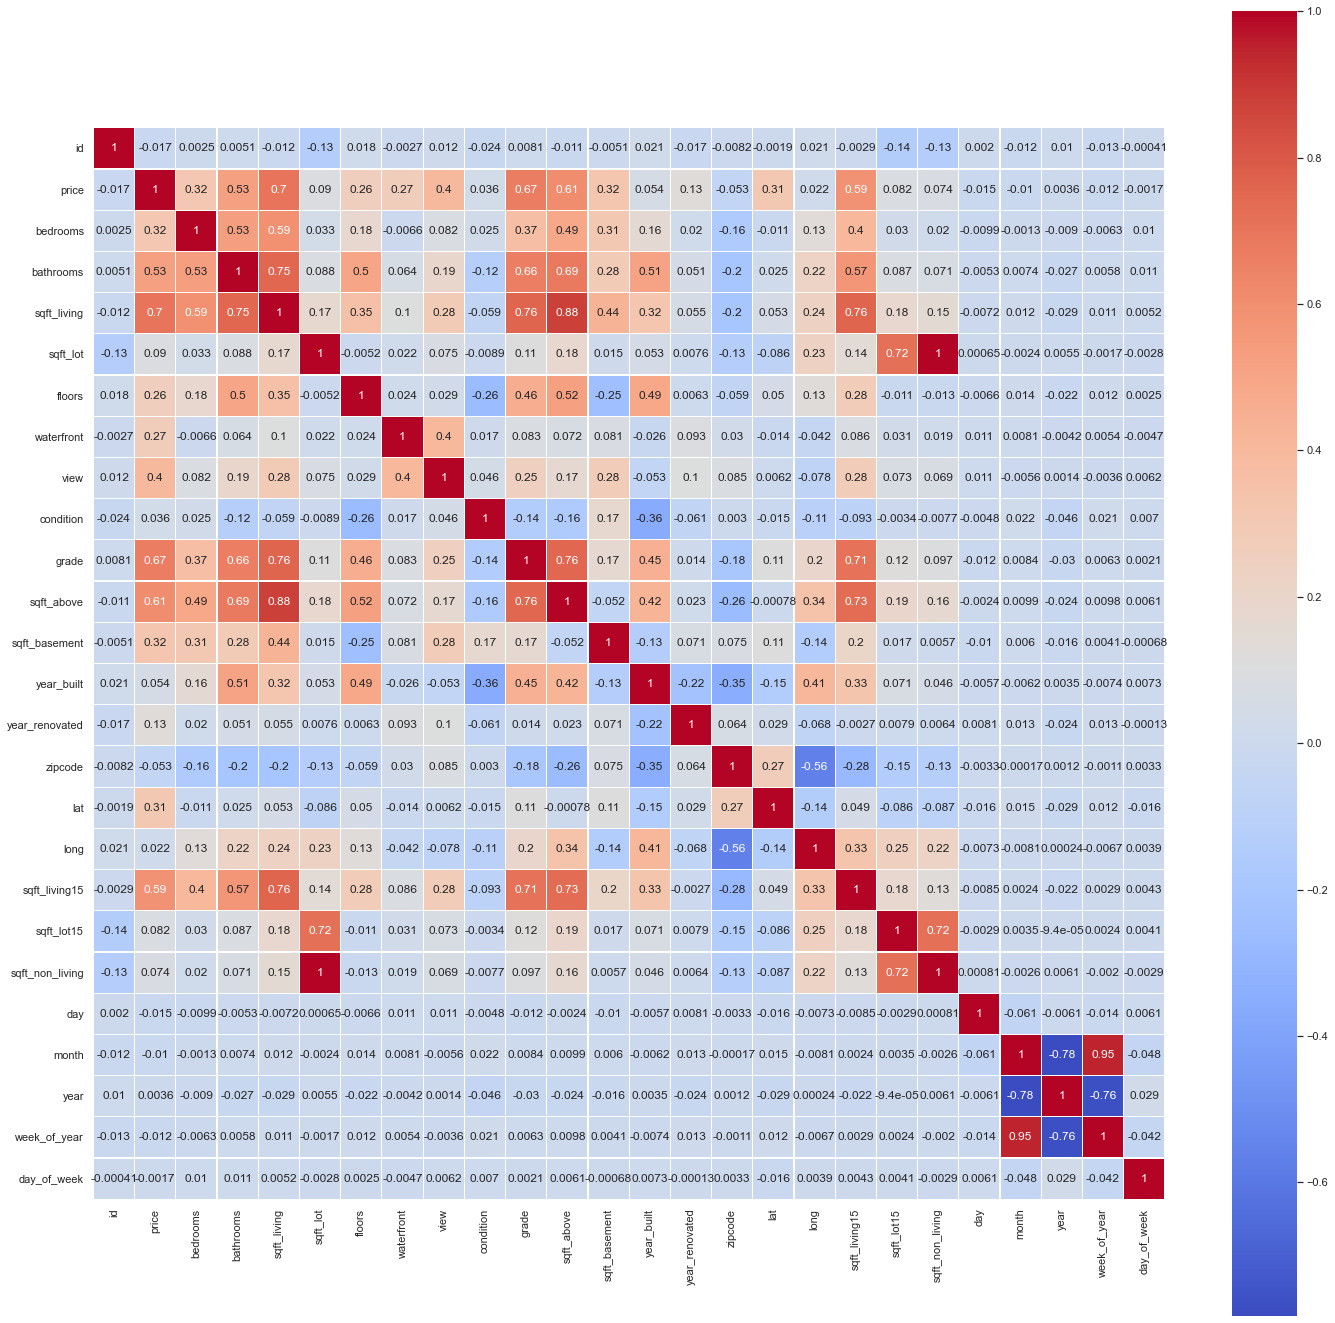

In [131]:
# A matriz de correlação mais clara que você já viu
# Depois de ler ‘Data Storytelling’ você nunca mais enxerga visualização de dados da mesma maneira. Cheguei nesse benchmark de nuances gráficas da matriz de correlação estudando 
# resoluções do Kaggle de outras pessoas, é meu xodó de matriz perfeita:

plt.figure(figsize=(24,24)) 
sns.heatmap(data=df3.corr(),annot=True,linewidths=0.2,cmap='coolwarm', square=True);

# 5.0 Data Preparation (Ou Pre-Processing ???) Qual diferença?

In [132]:
df5 = df3.copy()

In [133]:
df5.date.nunique()

372

In [134]:
df5.date.max() - df5.date.min()

Timedelta('390 days 00:00:00')

### 5.1 - Plot of Features, Searching for Outliers to choose MinMaxScaler or RobustScaler

In [135]:
# interessante, mas a escala, os valores do eixo Y não fazem o menor sentido...

# plt.figure(figsize=(20,12))
# aux = pd.DataFrame(data = np.random.random(size=(4,28)), columns = df5.columns)

# sns.boxplot(x="variable", y="value", data=pd.melt(aux))
# plt.xticks(rotation=45)
# plt.show()

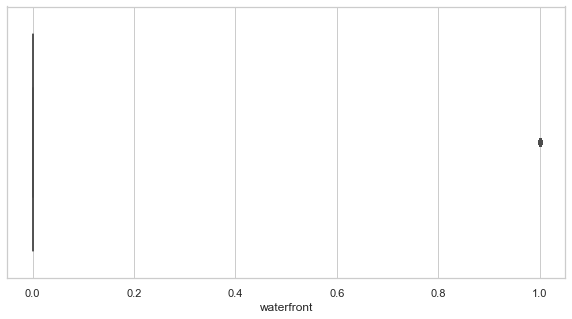

In [136]:
plt.rcParams['figure.figsize'] = [10, 5]
sns.boxplot('waterfront', data=df5);

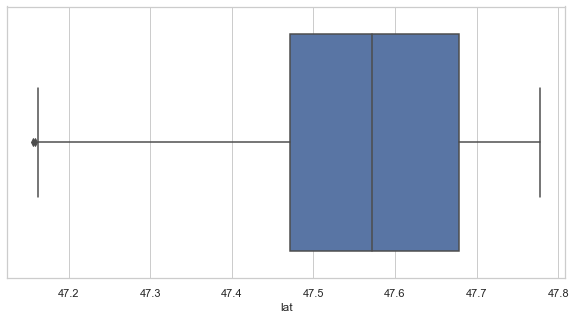

In [137]:
sns.boxplot('lat', data=df5);

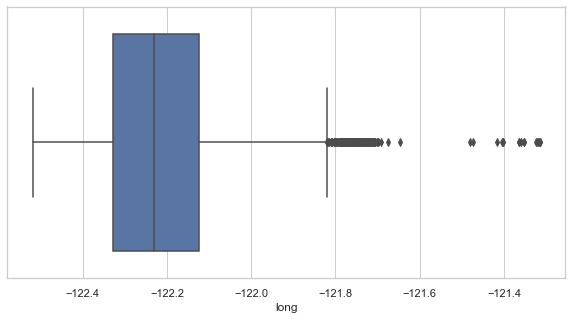

In [138]:
sns.boxplot('long', data=df5);

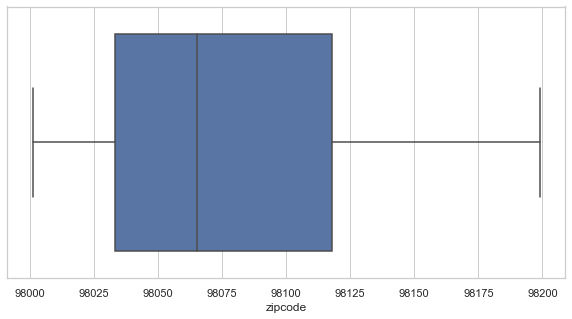

In [139]:
sns.boxplot('zipcode', data=df5);

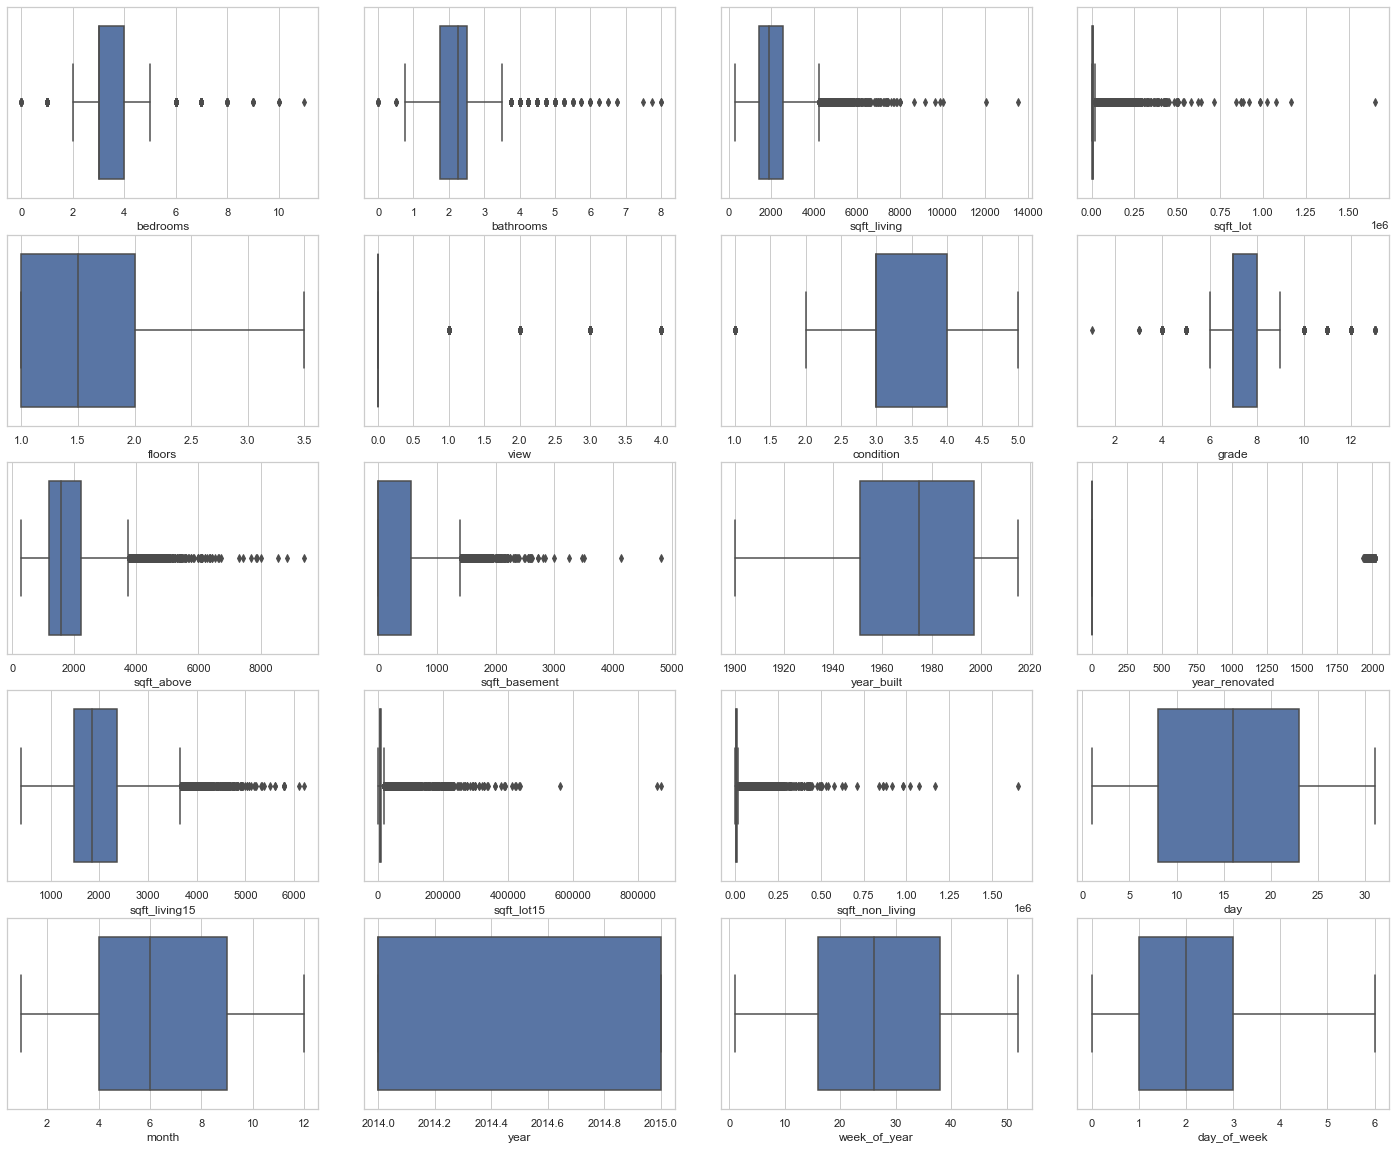

In [140]:
plt.rcParams['figure.figsize'] = [20, 16]
fig, axes = plt.subplots(5,4)
plt.tight_layout()

features = df5.drop(['id', 'date', 'price', 'zipcode', 'lat', 'long', 'season', 'waterfront'], axis=1).columns

for i in range(1, len(features) + 1):
    plt.subplot(5, 4, i)
    sns.boxplot(df5[features[i - 1]])

In [141]:
# método alternativo, utilizando axes[]

# plt.rcParams['figure.figsize'] = [20, 16]
# fig, axes = plt.subplots(nrows=5, ncols=4)
# plt.tight_layout()
# k = 0

# features = df5.drop(['id', 'date', 'price', 'zipcode', 'lat', 'long', 'season', 'waterfront'], axis=1).columns

# for i in range(5):
#     for j in range(4):
#         sns.boxplot(df5[features[k]], data=df5, ax=axes[i, j]);
#         k += 1

In [142]:
# stackoverflow method -- I didn't test it

# d = {'col1': [1, 2, 5.5, 100], 'col2': [3, 4, 0.2, 3], 'col3': [1, 4, 6, 30], 'col4': [2, 24, 0.2, 13], 'col5': [9, 84, 0.9, 3]}
# df = pd.DataFrame(data=d)

# names = list(df.columns)
# f, axes = plt.subplots(round(len(names)/3), 3)  
# y = 0;
# for name in names:
#     i, j = divmod(y, 3)
#     sns.boxplot(x=df[name], ax=axes[i, j])
#     y = y + 1

# plt.tight_layout()
# plt.show()

## 5.2 Normalização Ou Padronização? (qual está correto?) no sklearn é StandardScaler
- Com o StandardScaler, as distribuições mudam o seu formato
- Segundo Meigarom, nenhuma das variáveis vistas na análise univariada apresenta comportamento similar a uma normal, portanto, não utilizará a Padronização. Segundo o mesmo, a padronização só é útil em variáveis que aprensetam comportamento similar a uma distribuição normal. (conferir na literatura se é isso mesmo)

## 5.3 Rescaling Ou Normalização? (qual está correto?) no sklearn é MinMaxScaler ou RobustScaler
- Meigarom disse que MinMaxScaler é uma das técnicas de Rescaling
- Com o MinMax, as distribuições mantém o seu formato
- O MinMaxScaler é sensível a outliers


- Outra técnica de Rescaling é o RobustScaler
- Ele lida melhor com os outliers, pois utiliza o interquatile range, ao invés dos valores máximo e mínimo

- O RobustScaler tende a "apertar" a distribuição

In [143]:
rs = RobustScaler()
mms = MinMaxScaler()

In [144]:
# #path = 'D:/MEGA/Programming/Data Science/_My Projects/Rocket House/pickle/'
# # why do we need to use [[]] doubel brackets even for single feature? --> [[]] outputs like a Dataframe, not Series

# bedrooms_scaler = rs.fit(df5[['bedrooms']].values)
# pickle.dump(bedrooms_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\bedrooms_scaler.pkl', 'wb'))

# bathrooms_scaler = rs.fit(df5[['bathrooms']].values)
# pickle.dump(bathrooms_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\bathrooms_scaler.pkl', 'wb'))

# sqft_living_scaler = rs.fit(df5[['sqft_living']].values)
# pickle.dump(sqft_living_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\sqft_living_scaler.pkl', 'wb'))

# sqft_lot_scaler = rs.fit(df5[['sqft_lot']].values)
# pickle.dump(sqft_lot_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\sqft_lot_scaler.pkl', 'wb'))

# grade_scaler = rs.fit(df5[['grade']].values)
# pickle.dump(grade_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\grade_scaler.pkl', 'wb'))

# sqft_above_scaler = rs.fit(df5[['sqft_above']].values)
# pickle.dump(sqft_above_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\sqft_above_scaler.pkl', 'wb'))

# sqft_basement_scaler = rs.fit(df5[['sqft_basement']].values)
# pickle.dump(sqft_basement_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\sqft_basement_scaler.pkl', 'wb'))

# long_scaler = rs.fit(df5[['long']].values)
# pickle.dump(long_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\long_scaler.pkl', 'wb'))

# sqft_living15_scaler = rs.fit(df5[['sqft_living15']].values)
# pickle.dump(sqft_living15_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\sqft_living15_scaler.pkl', 'wb'))

# sqft_lot15_scaler = rs.fit(df5[['sqft_lot15']].values)
# pickle.dump(sqft_lot15_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\sqft_lot15_scaler.pkl', 'wb'))

# sqft_non_living_scaler = rs.fit(df5[['sqft_non_living']].values)
# pickle.dump(sqft_non_living_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\sqft_non_living_scaler.pkl', 'wb'))

# floors_scaler = mms.fit(df5[['floors']].values)
# pickle.dump(floors_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\floors_scaler.pkl', 'wb'))

# view_scaler = mms.fit(df5[['view']].values)
# pickle.dump(view_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\view_scaler.pkl', 'wb'))

# condition_scaler = mms.fit(df5[['condition']].values)
# pickle.dump(condition_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\condition_scaler.pkl', 'wb'))

# year_built_scaler = mms.fit(df5[['year_built']].values)
# pickle.dump(year_built_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\year_built_scaler.pkl', 'wb'))

# year_renovated_scaler = mms.fit(df5[['year_renovated']].values)
# pickle.dump(year_renovated_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\year_renovated_scaler.pkl', 'wb'))

# zipcode_scaler = mms.fit(df5[['zipcode']].values) # --> faz sentido usar zipcode? e usar scaler em zipcode?
# pickle.dump(zipcode_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\zipcode_scaler.pkl', 'wb'))

# lat_scaler = mms.fit(df5[['lat']].values)
# pickle.dump(lat_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\lat_scaler.pkl', 'wb'))

# year_scaler = mms.fit(df5[['year']].values)
# pickle.dump(year_scaler, open(r'D:\MEGA\Programming\Data Science\_My Projects\Rocket House\pickle\year_scaler.pkl', 'wb'))

# lala = mms.fit(df5[['year_renovated']].values)
# df5['year_renovated'] = lala.transform(df5[['year_renovated']].values)

# year_built_scaler = mms.fit(df5[['year_built']].values)
# df5['year_built'] = year_built_scaler.transform(df5[['year_built']].values)

In [145]:
# df5['bedrooms'] = bedrooms_scaler.transform(df5[['bedrooms']].values)

# df5['bathrooms'] = bathrooms_scaler.transform(df5[['bathrooms']].values)

# df5['sqft_living'] = sqft_living_scaler.transform(df5[['sqft_living']].values)

# df5['sqft_lot'] = sqft_lot_scaler.transform(df5[['sqft_lot']].values)

# df5['grade'] = grade_scaler.transform(df5[['grade']].values)

# df5['sqft_above'] = sqft_above_scaler.transform(df5[['sqft_above']].values)

# df5['sqft_basement'] = sqft_basement_scaler.transform(df5[['sqft_basement']].values)

# df5['long'] = long_scaler.transform(df5[['long']].values)

# df5['sqft_living15'] = sqft_living15_scaler.transform(df5[['sqft_living15']].values)

# df5['sqft_lot15'] = sqft_lot15_scaler.transform(df5[['sqft_lot15']].values)

# df5['sqft_non_living'] = sqft_non_living_scaler.transform(df5[['sqft_non_living']].values)

# df5['floors'] = floors_scaler.transform(df5[['floors']].values)

# df5['view'] = view_scaler.transform(df5[['view']].values)

# df5['condition'] = condition_scaler.transform(df5[['condition']].values)

# df5['year_built'] = year_built_scaler.transform(df5[['year_built']].values)

# df5['year_renovated'] = year_renovated_scaler.transform(df5[['year_renovated']].values)

# df5['zipcode'] = zipcode_scaler.transform(df5[['zipcode']].values) # --> faz sentido usar zipcode? e usar scaler em zipcode?

# df5['lat'] = lat_scaler.transform(df5[['lat']].values)

# df5['year'] = year_scaler.transform(df5[['year']].values)

# df5.sample(5)

In [146]:
df5['bedrooms'] = rs.fit_transform(df5[['bedrooms']].values)

df5['bathrooms'] = rs.fit_transform(df5[['bathrooms']].values)

df5['sqft_living'] = rs.fit_transform(df5[['sqft_living']].values)

df5['sqft_lot'] = rs.fit_transform(df5[['sqft_lot']].values)

df5['grade'] = rs.fit_transform(df5[['grade']].values)

df5['sqft_above'] = rs.fit_transform(df5[['sqft_above']].values)

df5['sqft_basement'] = rs.fit_transform(df5[['sqft_basement']].values)

df5['long'] = rs.fit_transform(df5[['long']].values)

df5['sqft_living15'] = rs.fit_transform(df5[['sqft_living15']].values)

df5['sqft_lot15'] = rs.fit_transform(df5[['sqft_lot15']].values)

df5['sqft_non_living'] = rs.fit_transform(df5[['sqft_non_living']].values)

df5['floors'] = mms.fit_transform(df5[['floors']].values)

df5['view'] = mms.fit_transform(df5[['view']].values)

df5['condition'] = mms.fit_transform(df5[['condition']].values)

df5['year_built'] = mms.fit_transform(df5[['year_built']].values)

df5['year_renovated'] = mms.fit_transform(df5[['year_renovated']].values)

df5['zipcode'] = mms.fit_transform(df5[['zipcode']].values) # --> faz sentido usar zipcode? e usar scaler em zipcode?

df5['lat'] = mms.fit_transform(df5[['lat']].values)

df5['year'] = mms.fit_transform(df5[['year']].values)

df5.sample(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_non_living,day,month,year,week_of_year,day_of_week,season
6252,1150900080,2015-04-27,846450.0,1.0,0.333333,1.602136,-0.022662,0.4,0,0.0,0.5,2.0,2.107843,0.000000,0.895652,0.0,0.141414,0.649349,1.054187,1.379310,-0.025887,-0.346428,27,4,1.0,18,0,Spring
8767,7812800515,2014-10-25,159075.0,1.0,-1.000000,-0.293725,-0.251228,0.0,0,0.0,0.5,-1.0,-0.754902,1.410714,0.382609,0.0,0.893939,0.548818,-0.049261,-0.597701,-0.224954,-0.195753,25,10,0.0,43,5,Fall
2050,8732040810,2014-11-04,235000.0,1.0,0.666667,-0.124611,0.454123,0.0,0,0.0,0.5,1.0,-0.303922,0.928571,0.686957,0.0,0.111111,0.243687,-0.763547,0.264368,0.140471,0.485610,4,11,0.0,45,1,Fall


## 5.4 Feature Transformation

### 5.4.1 Encoding (Variável Categórica --> Variável Numérica)

In [147]:
only_cat = df5.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
only_cat.columns

Index(['season'], dtype='object')

In [148]:
df5 = pd.get_dummies(df5, prefix=['season'], columns=['season'])

In [149]:
df5.sample()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_non_living,day,month,year,week_of_year,day_of_week,season_Fall,season_Spring,season_Summer,season_Winter
12091,1233100260,2014-11-14,490000.0,0.0,-1.666667,-0.578549,0.357456,0.4,0,0.0,0.75,0.0,-0.294118,0.0,0.173913,0.0,0.161616,0.838668,0.256158,-0.091954,0.040536,0.479145,14,11,0.0,46,4,1,0,0,0


### 5.4.2 Response Variable Transformation

In [150]:
df5['price'] = np.log1p(df5['price'])

### 5.4.3 Nature Transformation

In [151]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# day of month
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [152]:
df5.tail(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_non_living,day,month,year,week_of_year,day_of_week,season_Fall,season_Spring,season_Summer,season_Winter,day_of_week_sin,day_of_week_cos,day_sin,day_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
21611,291310100,2015-01-16,12.899222,0.0,0.333333,-0.275923,-0.926128,0.4,0,0.0,0.5,1.0,0.039216,0.0,0.904348,0.0,0.131313,0.608975,0.793103,-0.494253,-1.270857,-0.88394,16,1,1.0,3,4,0,0,0,1,-0.433884,-0.900969,-2.079117e-01,-0.978148,0.500000,0.866025,0.354605,0.935016
21612,1523300157,2014-10-15,12.691584,-1.0,-2.000000,-0.792167,-1.158412,0.4,0,0.0,0.5,0.0,-0.529412,0.0,0.939130,0.0,0.722222,0.704842,-0.339901,-0.942529,-1.256810,-1.01540,15,10,0.0,42,2,1,0,0,0,0.974928,-0.222521,1.224647e-16,-1.000000,-0.866025,0.500000,-0.935016,0.354605


# 6.0 Feature Selection

In [153]:
df6 = df5.copy()

## 6.1 Split Dataframe into Training and Test Dataset

In [154]:
# # dropar colunas que foram transformadas em outras -- com execção de date, pois vai servir pro cross validation time series
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'id']
df6 = df6.drop(cols_drop, axis=1)

In [155]:
# 4 semanas nesde dataset, dá em torno de 4% dos dados totais. no Rossmann, se usa em torno de 4.9%, e no Store Item Demand Forecast, 5% --> então acho que está ok
# como queremos prever as proximas 4 semanas de venda, vamos usar as 4 ultimas semanas dos dados como teste, e o resto como treino
# não sei se é o ideal, devido a overfitting, falta de aleatoriedade, etc, mas tudo bem, é a ideia de Meigarom, talvez seja assim em Time Series
df6['date'].max() - datetime.timedelta(days=4*7)

Timestamp('2015-04-29 00:00:00')

In [156]:
df6['date'].max()

Timestamp('2015-05-27 00:00:00')

In [157]:
X_train = df6[df6['date'] < '2015-04-29']
y_train = X_train['price']

X_test = df6[df6['date'] >= '2015-04-29']
y_test = X_test['price']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

print('\nTamanho treino: {}'.format(X_train.shape[0]))
print('Tamanho teste: {}'.format(X_test.shape[0]))

Training Min Date: 2014-05-02 00:00:00
Training Max Date: 2015-04-28 00:00:00

Test Min Date: 2015-04-29 00:00:00
Test Max Date: 2015-05-27 00:00:00

Tamanho treino: 20769
Tamanho teste: 843


## 6.2 Boruta as Feature Selector

In [158]:
# training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'price'], axis=1).values
y_train_n = y_train.values.ravel()

In [159]:
# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-2)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	19


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	19


### 6.2.1 Best Features from Boruta

In [160]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['date', 'price'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [161]:
cols_selected_boruta

['sqft_living',
 'sqft_lot',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'year_built',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'sqft_non_living']

In [162]:
cols_not_selected_boruta

['bathrooms',
 'bedrooms',
 'condition',
 'day_cos',
 'day_of_week_cos',
 'day_of_week_sin',
 'day_sin',
 'floors',
 'month_cos',
 'month_sin',
 'season_Fall',
 'season_Spring',
 'season_Summer',
 'season_Winter',
 'sqft_basement',
 'week_of_year_cos',
 'week_of_year_sin',
 'year',
 'year_renovated']

COMPARAR Resultado com as Conclusões das Hipóteses na Seção 4 !!!!!!!!!!!!!!

Não siga cegamente a sugestão do algortimo de seleção de features, use sua intuição e seus conhecimentos da análise exploratória de dados também
Você terá outros ciclos do CRISP para adicionar e/ou remover outras variáveis do modelo

Quero um gráfico com o o valor da relevância pro Modelo, tipo com a Árvore de Decisões

## 6.3 Manual Feature Selection

In [163]:
# foram incluídos os senos do month e do week_of_year, pois não faz sentido ter as funções de cos sem ter o seno no modelo, pois elas juntas é que representam as variáveis originais
cols_selected_boruta = [
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'year_built',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'sqft_non_living']

# columns to add
feat_to_add = ['date', 'price']
# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

## 6.4 Importance Selection

In [164]:
# training and test dataset for Importance Selection
X_train_i = X_train.drop(['date', 'price'], axis=1)

In [165]:
# SPLITAR UM CONJUNTO COM OS OUTLIERS  --> BATHROOM E BEDROOM = 0, E OUTRO SEM ELES

### 6.4.1 Feature Selection Using Random Forest Classifier

### 6.4.2 Feature Selection Using Extra-Trees Classifier

In [166]:
#https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f

In [167]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-5, random_state=42).fit(X_train_i, y_train_n)
#rf.score(X_test_n, y_test_n)

In [168]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train_i.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
grade,0.344574
lat,0.289307
sqft_living,0.176722
long,0.043576
sqft_living15,0.022426
year_built,0.018192
sqft_above,0.012219
sqft_lot15,0.012057
zipcode,0.009623
sqft_lot,0.008161


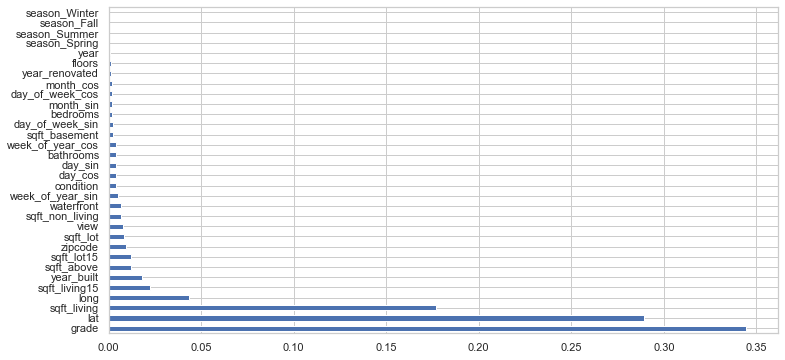

In [169]:
plt.rcParams['figure.figsize'] = [12, 6]
pd.Series(rf.feature_importances_, index=X_train_i.columns).nlargest(len(X_train_i.columns)).plot(kind='barh')  

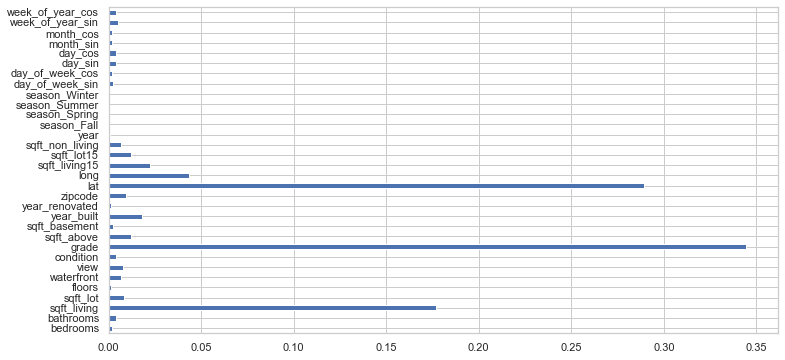

In [170]:
pd.Series(rf.feature_importances_, index=X_train_i.columns).plot(kind='barh')  

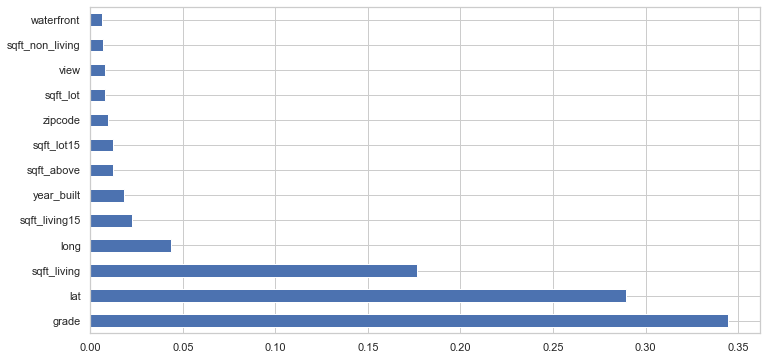

In [171]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train_i.columns)
feat_importances.nlargest(13).plot(kind='barh')

### 6.4.2 Feature Selection Using Extra-Trees Classifier

In [172]:
#https://iaexpert.academy/2020/07/14/selecao-de-atributos-com-extra-trees-classifier/?fbclid=IwAR2GSgCetW3k6M75dOS_oCQl01iTRzcZ-iTKSXRFCk1VrEQ_seb5xEMx7Ug

In [173]:
et = ExtraTreesRegressor(n_jobs=-5)
et.fit(X_train_n, y_train_n)

feature_importances = pd.DataFrame(et.feature_importances_,
                                   index = X_train_i.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
lat,0.275860
grade,0.202057
sqft_living,0.141903
sqft_living15,0.083614
sqft_above,0.059331
bathrooms,0.034365
long,0.026270
view,0.025049
year_built,0.023727
zipcode,0.017960


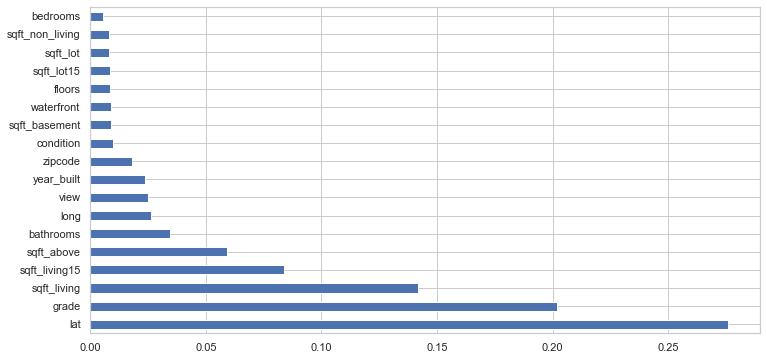

In [174]:
feat_importances = pd.Series(et.feature_importances_, index=X_train_i.columns)
feat_importances.nlargest(18).plot(kind='barh')

## 6.5 Selecting Columns Based on Everything (Hypothesis, Boruta and Feature Importances)

In [175]:
final_cols = [
'lat',
'grade',
'sqft_living',
'sqft_living15',
'sqft_above',
'long',          
'view',
'year_built',        # hypothesis made me think the year built woudln't matter much, but maybe it's because the range of values eluded me
'zipcode',               
'condition',                      
'waterfront',
'sqft_lot15',     
'sqft_lot',        
'sqft_non_living', 
'bedrooms'
]

# columns to add
feat_to_add = ['date', 'price']
# final features
final_cols_full = cols_selected_boruta.copy()
final_cols_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [176]:
x_train = X_train[final_cols]
x_test = X_test[final_cols]

# Time Series Data Preparation
x_training = X_train[final_cols_full]

## 7.1 Average Model

In [177]:
aux1 = x_test.copy()
aux1['price'] = y_test.copy()

# prediction
aux1['predictions'] = aux1['price'].mean()
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))  # exp pois as sales tinham sido transformados pra log
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,221462.254094,0.415894,398285.52194


## 7.2 Linear Regression Model

In [178]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,118897.050825,0.201624,202589.511012


### 7.2.1. Linear Regression Model - Cross Validation

In [179]:
lr_result_cv = log_time_series_cross_validation(x_training, 5, 4*7, 'Linear Regression', lr, 'price', verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,118045.05 +/- 3552.36,0.21 +/- 0.0,193113.57 +/- 4076.64


## 7.3 Linear Regression Regularized Model - Lasso

In [180]:
# model
lrr = Lasso(alpha=0.001).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr ))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,119390.626361,0.201641,204043.113457


### 7.3.1. Lasso - Cross Validation

In [181]:
lrr_result_cv = log_time_series_cross_validation( x_training, 5, 4*7, 'Lasso', lrr, target_col='price', verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,118494.13 +/- 3815.87,0.21 +/- 0.0,194165.65 +/- 4416.3


ESTES RESULTADOS DOS MODELOS LINEARES SEREM PIORES DO QUE O AVERAGE MODEL INDICAM QUE O FENÔMENO ESTUDADO NÃO POSSUI MUITAS CARACTERÍSTICAS LINEARES, ELE É UM FENÔMENO MAIS COMPLEXO, QUE VAI PRECISAR DE OUTROS TIPOS DE MODELOS NÃO LINEARES, MAIS COMPLEXOS

## 7.4 Random Forest Model

In [182]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-5, random_state=42 ).fit( x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,84749.769992,0.141752,162648.107983


In [183]:
# Desocupar espaço na memória, esse algoritmo ocupa muito!
#del rf

### 7.4.1. Random Forest Regressor - Cross Validation

In [184]:
rf_result_cv = log_time_series_cross_validation(x_training, 5, 4*7, 'Random Forest Regressor', rf, 'price', verbose=True )
rf_result_cv


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,77894.3 +/- 2630.67,0.14 +/- 0.0,144488.37 +/- 4427.98


## 7.5 XGBoost Regressor

In [185]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=200,
                              n_jobs=-5,
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9).fit( x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result
# com a versão 0.9.0 do xgboost ele se dá muito melhor
# ou depois do tuning também

[19:54:42] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,460471.10159,0.820597,584065.033171


### 7.5.1. XGBoost Regressor - Cross Validation

In [186]:
xgb_result_cv = log_time_series_cross_validation(x_training, 5, 4*7, 'XGBoost Regressor', model_xgb, 'price', verbose=True)
xgb_result_cv


KFold Number: 1
[19:54:43] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 2
[19:54:43] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 3
[19:54:44] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,452895.31 +/- 11082.21,0.81 +/- 0.0,563312.39 +/- 11410.66


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [187]:
# modeling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
# modeling_result.to_pickle('modeling_result.pkl')
# modeling_result.sort_values('RMSE')

In [188]:
file = open("modeling_result.pkl",'rb')
modeling_result = pickle.load(file)
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,70332.955407,0.127934,127792.403184
0,Linear Regression - Lasso,117459.131162,0.210787,256152.251243
0,Linear Regression,117302.227112,0.210618,257470.598709
0,Average Model,224575.262238,0.444310,371912.689563
0,XGBoost Regressor,451116.613267,0.809318,559422.811817


### 7.6.2. Real Performance - Cross Validation

In [189]:
# modeling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] ) 
# modeling_result_cv.to_pickle('modeling_result_cv.pkl')
# modeling_result_cv.sort_values('RMSE CV')

In [190]:
file = open("modeling_result_cv.pkl",'rb')
modeling_result_cv = pickle.load(file)
modeling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,77894.3 +/- 2630.67,0.14 +/- 0.0,144488.37 +/- 4427.98
0,Linear Regression,118045.05 +/- 3552.36,0.21 +/- 0.0,193113.57 +/- 4076.64
0,Lasso,118494.13 +/- 3815.87,0.21 +/- 0.0,194165.65 +/- 4416.3
0,XGBoost Regressor,452895.31 +/- 11082.21,0.81 +/- 0.0,563312.39 +/- 11410.66


# 8.0 Hyperparameter Fine Tuning

In [191]:
param = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400]}

## 8.1 Random Search

In [192]:
# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param,
#     n_iter=100,
#     n_jobs=-5,
#     cv=5,
#     random_state=0
# )

# search = random_search.fit(x_train, y_train)
# search.best_params_

## 8.2 Bayesian Search

In [193]:
# bayes_search = BayesSearchCV(
#     estimator=model_xgb,
#     search_spaces=param,
#     n_jobs=-5,
#     n_iter=30,
#     random_state=0,
#     cv=5
#  )
# bayes_search.fit(X_train, y_train)
# bayes_search.score(X_test, y_test)

# tá dando erro, sabe-se lá pq: TypeError: object.__init__() takes exactly one argument (the instance to initialize)

## 8.3 Final Model

In [194]:
param_tuned = {
 'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [195]:
model_rf_tuned = RandomForestRegressor(n_estimators=400, n_jobs=-5, random_state=42, min_samples_split=2, min_samples_leaf=1,
                                      max_features='sqrt', max_depth=30, bootstrap=False).fit(x_train, y_train)

# prediction
yhat_rf_tuned = model_rf_tuned.predict(x_test)

# performance
rf_result_tuned = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf_tuned))
rf_result_tuned

,Model Name,MAE,MAPE,RMSE
0,Random Forest,83537.210067,0.141512,158697.634223


In [198]:
mpe = mean_percentage_error(y_test , yhat_rf_tuned)
mpe  # mpe > 0   -->  o modelo está subestimando os preços

0.005921721503356651

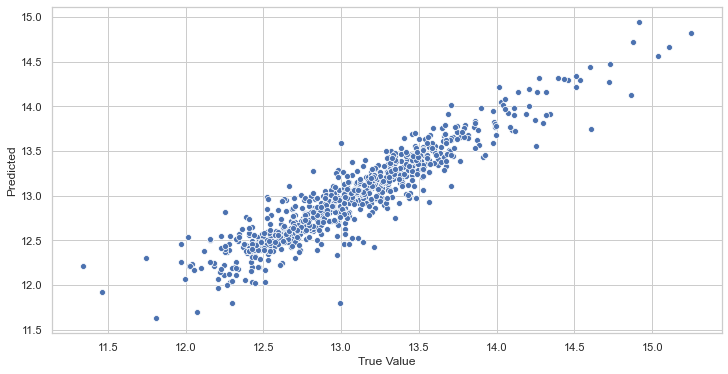

In [199]:
# real x predito
sns.scatterplot(x= y_test, y= yhat_rf_tuned );
plt.xlabel('True Value');
plt.ylabel('Predicted');

In [200]:
# 	Model Name	         MAE	        MAPE	     RMSE
# 	Random Forest	83537.210067	0.141512	158697.634223

In [201]:
#save trained model
pickle.dump(model_rf_tuned, open(r'D:\MEGA\Programming\Data Science\_My Projects\Store Item Demand Forecasting Challenge\model_rockethouse_rf_tuned.pkl', 'wb'))

### APRENDER ARIMA PRA APLICAR NESTE E OUTROS CASOS DE TIME SERIES

# 9.0 Tradução e Interpretação do Erro

In [202]:
df9 = X_test.copy()

df9.loc[:, 'price'] =  np.expm1(df9.loc[:, 'price'])
df9.loc[:, 'predictions'] = np.expm1(yhat_rf_tuned)

In [203]:
df9.to_csv('D:\df9.csv')

In [204]:
df9.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_non_living,year,season_Fall,season_Spring,season_Summer,season_Winter,day_of_week_sin,day_of_week_cos,day_sin,day_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,predictions
119,2015-05-11,535000.0,1.0,-1.666667,-0.267023,-0.820962,0.2,0,0.0,0.75,0.0,0.049020,0.000000,0.217391,0.000000,0.722222,0.693421,-0.315271,-0.264368,-0.718407,-0.779060,1.0,0,1,0,0,0.000000,1.000000,0.743145,-0.669131,0.5,-0.866025,0.663123,-0.748511,4.880337e+05
142,2015-05-08,205000.0,0.0,-1.666667,-0.267023,0.169964,0.0,0,0.0,0.75,0.0,-0.539216,1.071429,0.539130,0.000000,0.287879,0.483191,0.290640,-0.264368,0.192445,0.226103,1.0,0,1,0,0,-0.433884,-0.900969,0.994522,-0.104528,0.5,-0.866025,0.748511,-0.663123,2.817709e+05
269,2015-05-04,2900000.0,1.0,1.333333,2.794838,2.209711,0.2,0,0.5,0.50,4.0,3.127451,0.535714,0.713043,0.996526,0.015152,0.764517,0.034483,2.356322,2.496363,1.677367,1.0,0,1,0,0,0.000000,1.000000,0.743145,0.669131,0.5,-0.866025,0.748511,-0.663123,2.475923e+06
271,2015-05-01,436000.0,-1.0,-1.666667,-0.774366,-0.014341,0.0,0,0.0,0.75,0.0,-0.509804,0.000000,0.339130,0.000000,0.666667,0.892392,-0.600985,-0.459770,-0.018061,0.141517,1.0,0,1,0,0,-0.433884,-0.900969,0.207912,0.978148,0.5,-0.866025,0.822984,-0.568065,3.595858e+05
278,2015-05-05,455000.0,1.0,0.333333,0.267023,7.392732,0.0,0,0.0,0.50,1.0,0.637255,0.000000,0.843478,0.000000,0.186869,0.364967,0.783251,0.954023,8.381077,7.444888,1.0,0,1,0,0,0.781831,0.623490,0.866025,0.500000,0.5,-0.866025,0.748511,-0.663123,4.437397e+05


In [205]:
len(df9.predictions)

843

## 9.1 Business Performacne

In [206]:
model_summary = rf_result_tuned.drop('Model Name', axis=1)

In [207]:
# What's the Mean and Sum of all Houses Sold in this Model?
model_summary['Sum_of_Predictions'] = df9['predictions'].sum()
model_summary['Mean_of_Predictions'] = df9['predictions'].mean()
# sum predictions is the sum of the houses' price sold during the next 4 weeks

# Scenarios

model_summary['Lowest_Daily_Price'] = model_summary['Mean_of_Predictions'] - model_summary['MAE']
model_summary['Highest_Daily_Price'] = model_summary['Mean_of_Predictions'] + model_summary['MAE']
model_summary['4_Week_Low_Scenario'] = model_summary['Sum_of_Predictions'] - model_summary['Sum_of_Predictions'] * model_summary['MAPE']
model_summary['4_Week_High_Scenario'] = model_summary['Sum_of_Predictions'] + model_summary['Sum_of_Predictions'] * model_summary['MAPE']

model_summary

,MAE,MAPE,RMSE,Sum_of_Predictions,Mean_of_Predictions,Lowest_Daily_Price,Highest_Daily_Price,4_Week_Low_Scenario,4_Week_High_Scenario
0,83537.210067,0.141512,158697.634223,4.169485e+08,494600.871147,411063.661081,578138.081214,3.579454e+08,4.759517e+08


## 9.2 Total Performance

In [208]:
performance = model_summary[['Sum_of_Predictions', 'Mean_of_Predictions', 'Lowest_Daily_Price', 'Highest_Daily_Price', '4_Week_Low_Scenario', '4_Week_High_Scenario']].applymap('$ {:,.2f}'.format)
performance

,Sum_of_Predictions,Mean_of_Predictions,Lowest_Daily_Price,Highest_Daily_Price,4_Week_Low_Scenario,4_Week_High_Scenario
0,"$ 416,948,534.38","$ 494,600.87","$ 411,063.66","$ 578,138.08","$ 357,945,395.50","$ 475,951,673.25"


## 9.3 Machine Learning Performance

In [209]:
df9.loc[:, 'error'] = df9.loc[:, 'price'] - df9.loc[:, 'predictions']
df9.loc[:, 'error_rate'] = df9.loc[:, 'predictions'] / df9.loc[:, 'price']

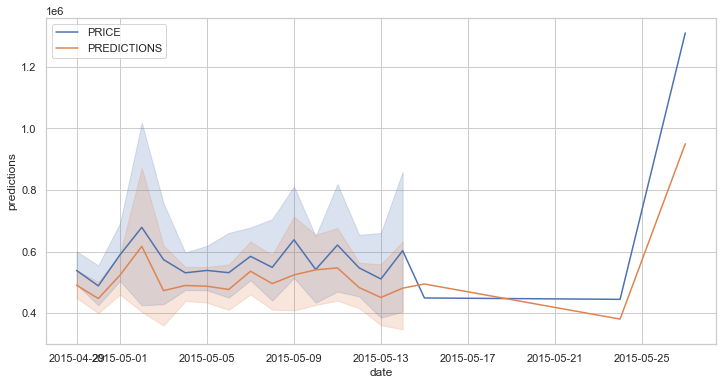

In [210]:
# By default, the plot aggregates over multiple y values at each value of x and shows an estimate of the central tendency and a confidence interval for that estimate.
sns.lineplot(x='date', y='price', data=df9, label='PRICE');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');

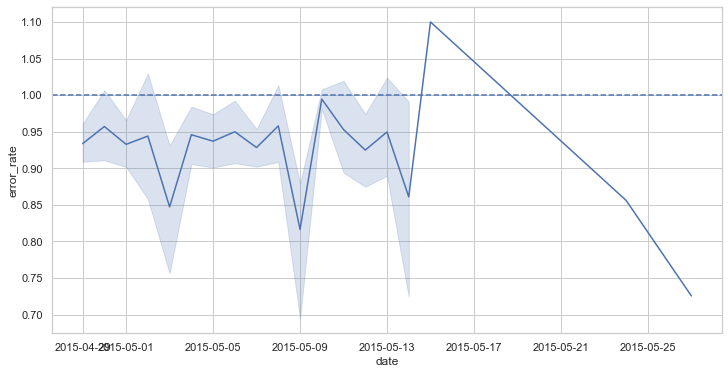

In [211]:
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--');

# comportamento estranho a patir do 13-05

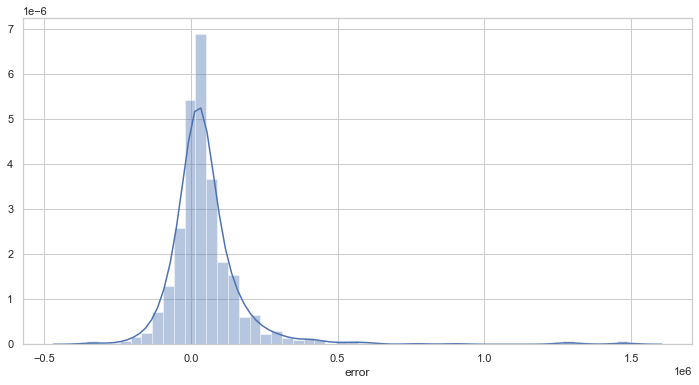

In [212]:
sns.distplot(df9['error']);
# o erro segue uma distribuição normal, é um bom sinal de que não há viés e coisa do tipo (estudar análise de resíduos)
# na real, Meigarom que disse isso, mas parece que não procede. basta o erro ser aleatório, e não viesado

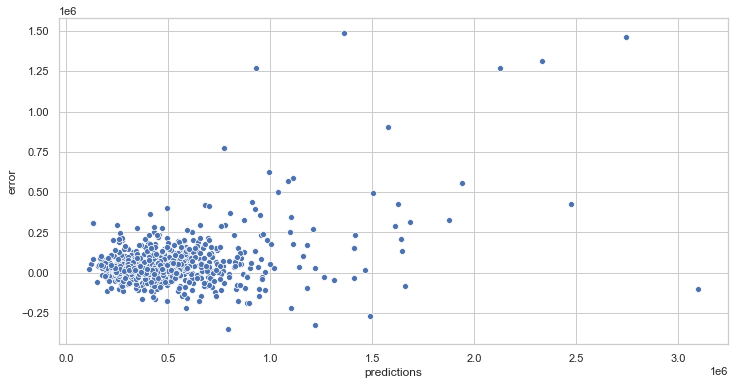

In [213]:
sns.scatterplot(df9['predictions'], df9['error']);

# 10 DEPLOY MODEL TO PRODUCTION

### Requirements.txt

## 10.1 Project Class

## 10.2 API Handler

## 10.3 API Tester